# Extract the  result of auto Graph Convolutional Network for ST deconvolution

In [1]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numexpr as ne
import numpy as np
import pandas as pd
import re
import seaborn as sns

import scipy
import scanpy
import tifffile

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, NNConv, global_max_pool
from torch_geometric.data import Data, DataLoader, InMemoryDataset
from torch_scatter import scatter_mean
from torch import optim

import sklearn.neighbors as skgraph
from scipy import sparse as sp
import networkx as nx

import sys

# 1.1 Read the data

In [19]:
data_dir='/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/correct_version/5_Human_ovarian'
output_dir='/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/correct_version/5_Human_ovarian/output_result'

(41048, 30035, 3)


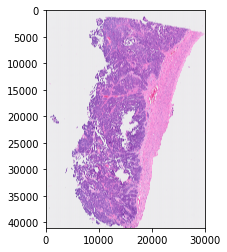

In [3]:
### 1.1 Read the image file

image_file = os.path.join(data_dir, '5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image.tif')
image = tifffile.imread(os.path.join(image_file))
print(image.shape)
image_norm = image.copy()
plt.imshow(image_norm)
plt.show()

In [ ]:
### 1.2 Read the ST data

### 1.2.1 The gene expression matrix
gene_matrix = scanpy.read_mtx("/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/5_Human_ovarian/data/filtered_feature_bc_matrix/matrix.mtx")

### 1.2.2. The spatial barcodes matrix

barcodes = pd.read_csv('/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/5_Human_ovarian/data/filtered_feature_bc_matrix/barcodes.tsv', 
                       header=None)
barcodes

### 1.2.3. The gene features matrix

genes = pd.read_csv('/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset/5_Human_ovarian/data/filtered_feature_bc_matrix/features.tsv', 
                       header=None, sep='\t')
genes

### 1.2.4 Read the spatial positions data
spatial = pd.read_csv(os.path.join(data_dir,'data', 'spatial', 'tissue_positions.csv'), index_col=0)
spatial

In [36]:
### 1.3 Read the HD-staining result or from other cell segmentation and feature extraction method

nuclei_data_df = pd.read_csv('/project/DPDS/Xiao_lab/shared/zhuoyu_wen/spatial_profiling/feature_vectors/results/10x_Genomics/5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image/(5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma_tissue_image)_information_model40_image20.csv')

In [37]:
nuclei_data_df

nucleus_id nucleus_class  \
0       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
1       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
2       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...        stroma   
3       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
4       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
...                                                   ...           ...   
364658  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...        stroma   
364659  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...         blood   
364660  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...         blood   
364661  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...         blood   
364662  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...        stroma   

        centroid_x0  centroid_y0  area  convex_area  eccentricity    extent  \
0             16035           57  1609         1631      0.528023  0.778046   
1             15949           92  1479         1500      0.783045  0.763158   
2             15927           28   926          943      0.854123  0.645296   
3             15966           71   978         1011      0.696526  0.756966   
4             15994           90  1259         1277      0.489100  0.773342   
...             ...          ...   ...          ...           ...       ...   
364658        16863        40944  1515         1559      0.702737  0.717330   
364659        16891        41006   820          845      0.663016  0.759259   
364660        16914        40964  2112         2225      0.888688  0.700498   
364661        16836        40950   288          289      0.772019  0.935065   
364662        16893        40957   985         1010      0.795637  0.703571   

        filled_area  major_axis_length  ...  mask_feature_247  \
0              1609          49.368783  ...          0.638172   
1              1479          55.272426  ...          0.728006   
2               926          47.824206  ...          0.234811   
3               978          42.057786  ...          0.530749   
4              1259          43.018249  ...          0.576939   
...             ...                ...  ...               ...   
364658         1515          52.655006  ...          0.246284   
364659          820          37.750067  ...          0.224713   
364660         2112          77.526718  ...          0.145999   
364661          288          24.182075  ...          0.415321   
364662          985          45.587347  ...          0.116748   

        mask_feature_248  mask_feature_249  mask_feature_250  \
0               0.001287          0.067700          0.002586   
1               0.009713          0.101069          0.000379   
2               0.002930          0.026560          0.016710   
3               0.009651          0.065756          0.007254   
4               0.008349          0.054109          0.010228   
...                  ...               ...               ...   
364658          0.003384          0.051266          0.002767   
364659          0.009578          0.024974          0.004801   
364660          0.001760          0.034504          0.002725   
364661          0.002220          0.025273          0.000121   
364662          0.001581          0.039843          0.007271   

        mask_feature_251  mask_feature_252  mask_feature_253  \
0               0.046827          0.016204          0.025996   
1               0.173253          0.033755          0.044094   
2               0.001363          0.042367          0.048907   
3               0.015017          0.037435          0.033498   
4               0.045466          0.014455          0.029350   
...                  ...               ...               ...   
364658          0.002801          0.042497          0.060804   
364659          0.002446          0.021116          0.049722   
364660          0.003656          0.061455          0.070237   
364661 

In [38]:
nuclei_data_df['nucleus_class'].value_counts()

tumor                183160
stroma                73116
ductal epithelium     56383
blood                 26429
lymphocyte            13310
necrosis               8976
macrophage             3289
Name: nucleus_class, dtype: int64

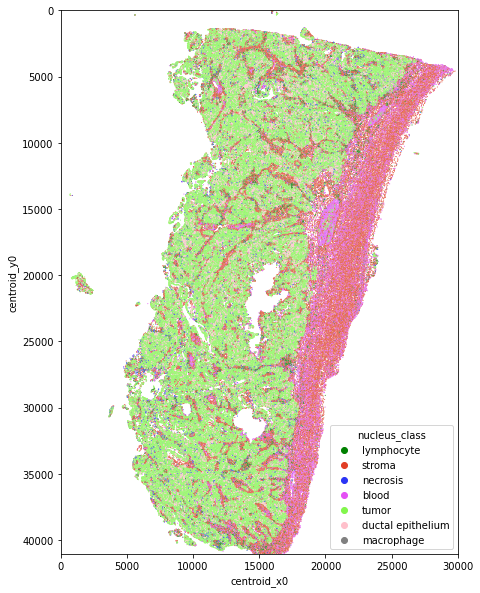

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

#0dd149
# Define your custom color palette
my_color_palette = ["green", "#E13E25", "#2A34F5", "#E450F5","#82F64C", "pink","grey"]

plt.figure(figsize=(10, 10))
sns.scatterplot(
    x=nuclei_data_df['centroid_x0'],
    y=nuclei_data_df['centroid_y0'],
    hue=nuclei_data_df['nucleus_class'],
    palette=my_color_palette,  # Assign the custom color palette
    s=1
)
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()


/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


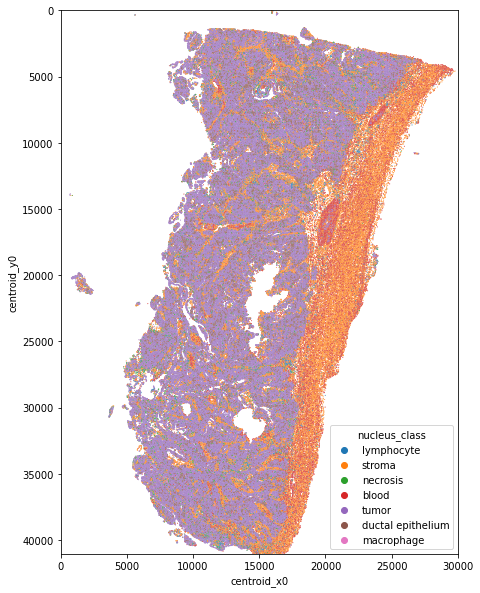

In [40]:
plt.figure(figsize=(10, 10))
sns.scatterplot(nuclei_data_df['centroid_x0'], nuclei_data_df['centroid_y0'], hue=nuclei_data_df['nucleus_class'], s=1)
plt.gca().set_aspect('equal')
plt.xlim(0, image.shape[1])
plt.ylim(image.shape[0], 0)
plt.show()

# 1.2 Data pre-processing

### 1.2.1 Pre-processing the gene expression matrix

In [31]:
count_df = pd.read_csv(os.path.join(output_dir, 'count_norm.csv'), index_col=0)
count_df

# Normalize count_df
count_stat = pd.read_csv(os.path.join(output_dir, 'count_stat.csv'), index_col=0)
count_stat

# Log2
'''
count_df = np.log2(count_df + 1)

# Normalize gene_stat by divided with max
count_max = np.log2(count_stat.loc['max', :].values + 1)
count_max[count_max < 1] = 1
'''
count_max = count_stat.loc['tile_95', :].values
count_max[count_max < 1] = 1
count_df = count_df/count_max

# Only keep count_stat with non_zero_p > 0.1
# count_df = count_df.loc[:, count_stat.loc['non_zero_p', :].values > 0.2]

In [32]:
meta_df = pd.read_csv(os.path.join(output_dir, 'meta_df.csv'), index_col=0)
meta_df

pxl_col_in_fullres  pxl_row_in_fullres
barcode                                                   
AACAATGTGCTCCGAG-1                4830               29958
AACACCATTCGCATAC-1                8366               15758
AACACGTTGATACCGC-1               17813               25910
AACACTCGTGAGCTTC-1               10504               27140
AACAGCCTCCTGACTA-1               12125               31887
...                                ...                 ...
TGTTGCTATCGGTGGC-1               12639               39153
TGTTGGCCTGTAGCGG-1               19523               11706
TGTTGGTGCGCACGAG-1               14069                6626
TGTTGGTGCGGAATCA-1               17816               25279
TGTTGGTGGACTCAGG-1               14343               26212

[4674 rows x 2 columns]

In [33]:
count_df

SIGIRR  NTS     PRKCQ   SLC66A1    NDUFS1  CFAP58  \
AACAATGTGCTCCGAG-1  0.884756  0.0  0.000000  0.767167  0.267907     0.0   
AACACCATTCGCATAC-1  0.681495  0.0  0.000000  0.984868  1.031797     0.0   
AACACGTTGATACCGC-1  0.251788  0.0  0.000000  0.363874  0.381213     0.0   
AACACTCGTGAGCTTC-1  0.449934  0.0  0.624986  0.000000  0.510907     0.0   
AACAGCCTCCTGACTA-1  0.537952  0.0  0.597799  0.621941  0.488682     0.0   
...                      ...  ...       ...       ...       ...     ...   
TGTTGCTATCGGTGGC-1  0.595705  0.0  0.827471  0.000000  0.450955     0.0   
TGTTGGCCTGTAGCGG-1  0.722263  0.0  0.000000  0.745560  0.702977     0.0   
TGTTGGTGCGCACGAG-1  0.336292  0.0  0.000000  0.485995  0.763730     0.0   
TGTTGGTGCGGAATCA-1  0.313239  0.0  0.580145  0.000000  0.711376     0.0   
TGTTGGTGGACTCAGG-1  0.619166  0.0  0.000000  0.671095  0.644483     0.0   

                       FOLH1     XRCC1  RBFOX3   FAM200A  ...  HIST1H4B  \
AACAATGTGCTCCGAG-1  0.000000  0.596940     0.0  0.000000  ...       0.0   
AACACCATTCGCATAC-1  0.000000  0.638613     0.0  0.000000  ...       0.0   
AACACGTTGATACCGC-1  0.000000  0.707835     0.0  0.000000  ...       0.0   
AACACTCGTGAGCTTC-1  0.000000  0.442704     0.0  0.220979  ...       0.0   
AACAGCCTCCTGACTA-1  0.635479  0.544431     0.0  0.422733  ...       0.0   
...                      ...       ...     ...       ...  ...       ...   
TGTTGCTATCGGTGGC-1  0.000000  0.251199     0.0  0.000000  ...       0.0   
TGTTGGCCTGTAGCGG-1  0.000000  0.464102     0.0  0.000000  ...       0.0   
TGTTGGTGCGCACGAG-1  0.000000  0.378158     0.0  0.000000  ...       0.0   
TGTTGGTGCGGAATCA-1  0.000000  0.410941     0.0  0.205125  ...       0.0   
TGTTGGTGGACTCAGG-1  0.914271  0.783278     0.0  0.304095  ...       0.0   

                     ARFGAP2     RNPS1    ZNF343    RSPO2   ZKSCAN8    KANSL3  \
AACAATGTGCTCCGAG-1  0.235796  1.077967  0.363220   0.0000  0.279368  1.063165   
AACACCATTCGCATAC-1  0.302708  0.553546  0.000000   0.0000  0.358645  0.454954   
AACACGTTGATACCGC-1  0.167760  0.920321  0.387627  25.3614  1.093179  1.008537   
AACACTCGTGAGCTTC-1  0.449668  0.274095  0.808115   0.0000  0.355174  0.788466   
AACAGCCTCCTGACTA-1  0.430108  0.524344  0.441693   0.0000  0.594518  0.592560   
...                      ...       ...       ...      ...       ...       ...   
TGTTGCTATCGGTGGC-1  0.198451  0.362897  0.611389   0.0000  0.822928  0.447392   
TGTTGGCCTGTAGCGG-1  0.274985  0.439995  0.635382   0.0000  0.814498  0.568272   
TGTTGGTGCGCACGAG-1  0.000000  0.409731  0.690293   0.0000  0.530933  0.336754   
TGTTGGTGCGGAATCA-1  0.695677  0.572466  1.071622   0.0000  0.659383  0.575061   
TGTTGGTGGACTCAGG-1  0.206267  0.565784  0.397168   0.0000  0.549860  0.658768   

                      HSPA14      TBCE   TMSB15B  
AACAATGTGCTCCGAG-1  0.645868  0.649475  0.567332  
AACACCATTCGCATAC-1  0.276383  0.000000  0.000000  
AACACGTTGATACCGC-1  0.612682  0.577597  0.000000  
AACACTCGTGAGCTTC-1  0.547417  1.135352  0.000000  
AACAGCCTCCTGACTA-1  0.261802  0.493620  0.000000  
...                      ...       ...       ...  
TGTTGCTATCGGTGGC-1  0.543578  0.819920  0.477480  
TGTTGGCCTGTAGCGG-1  0.376606  0.284032  0.000000  
TGTTGGTGCGCACGAG-1  0.409153  0.000000  0.000000  
TGTTGGTGCGGAATCA-1  0.508141  0.766468  0.000000  
TGTTGGTGGACTCAGG-1  0.282493  0.639159  0.000000  

[4674 rows x 18061 columns]

In [34]:
spatial

in_tissue  array_row  array_col  pxl_row_in_fullres  \
barcode                                                                   
CGAGGATATTCAGAGC-1          0          0          0                -862   
TCTGGTACTAATGCGG-1          0          0          2                -864   
AGGTGACCATGACGCT-1          0          0          4                -866   
CAGAGGTGTACGTAGC-1          0          0          6                -867   
TAGCTAGAAGATACAT-1          0          0          8                -869   
...                       ...        ...        ...                 ...   
CATTATCAGAAGCCTT-1          0        127        215               39067   
AAGTACAACCATAGTC-1          0        127        217               39065   
TGTATCCGCAGTTATC-1          0        127        219               39064   
ATACGCATCCTTCATA-1          0        127        221               39062   
CTTCAACGAGCAGGCT-1          0        127        223               39060   

                    pxl_col_in_fullres  
barcode                                 
CGAGGATATTCAGAGC-1               33824  
TCTGGTACTAATGCGG-1               33459  
AGGTGACCATGACGCT-1               33093  
CAGAGGTGTACGTAGC-1               32728  
TAGCTAGAAGATACAT-1               32363  
...                                ...  
CATTATCAGAAGCCTT-1               -5620  
AAGTACAACCATAGTC-1               -5985  
TGTATCCGCAGTTATC-1               -6350  
ATACGCATCCTTCATA-1               -6715  
CTTCAACGAGCAGGCT-1               -7080  

[14336 rows x 5 columns]

## 1.2.2 pre-processing of the image

In [41]:
nn=(max(meta_df['pxl_row_in_fullres'])-min(meta_df['pxl_row_in_fullres'])+max(meta_df['pxl_col_in_fullres'])-min(meta_df['pxl_col_in_fullres']))/2
print(nn)
###with 11 mm capture areas
###the resolution is 
print(11*1000/nn)
### Cacluate the SPOT_RADIUS
# 55 um / 0.546 mpp / 2= 110 pixels
### the number is the different in meta_df column 
#mpp = 100/366
#print(mpp)

36071.0
0.3049541182667517


In [42]:

mpp = 100/366
SPOT_RADIUS = 30/mpp/2
print(mpp)
print('SPOT_RADIUS: {}'.format(SPOT_RADIUS))

0.273224043715847
SPOT_RADIUS: 54.89999999999999


## 1.2.2  Pre-processing nuclei_data_df

In [43]:
### 1.2.2.1 Normalize nuclei_data_df
feature_names = [_ for _ in nuclei_data_df.columns.values[4:] if 'bbox' not in _ and 'orientation' not in _
                and 'probability_vector' not in _]
print("N features:", len(feature_names), feature_names[:20], "...")
# nuclei_data_norm_df = (nuclei_data_df.loc[:, feature_names] - np.mean(nuclei_data_df.loc[:, feature_names], axis=0))/\
#                         np.std(nuclei_data_df.loc[:, feature_names], axis=0)
nuclei_data_norm_df = nuclei_data_df.loc[:, feature_names]
feature_names_to_normalize = ['area', 'convex_area', 'eccentricity', 'extent', 'filled_area', 
                            'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity', 'probability']
nuclei_data_norm_df.loc[:, feature_names_to_normalize] = (nuclei_data_df.loc[:, feature_names_to_normalize] - \
                                                          np.mean(nuclei_data_df.loc[:, feature_names_to_normalize], axis=0))/\
                        np.std(nuclei_data_df.loc[:, feature_names_to_normalize], axis=0)

N features: 1290 ['area', 'convex_area', 'eccentricity', 'extent', 'filled_area', 'major_axis_length', 'minor_axis_length', 'perimeter', 'solidity', 'probability', 'box_feature_1', 'box_feature_2', 'box_feature_3', 'box_feature_4', 'box_feature_5', 'box_feature_6', 'box_feature_7', 'box_feature_8', 'box_feature_9', 'box_feature_10'] ...


In [44]:
# Nucleus class numeric
temp = []
for i, _ in enumerate(nuclei_data_df['nucleus_class'].values):
    if _ == 'tumor':
        temp.append(1)
    elif _ == 'stroma':
        temp.append(2)
    elif _ == 'lymphocyte':
        temp.append(3)
    elif _ == 'blood':
        temp.append(4)
    elif _ == 'macrophage':
        temp.append(5)
    elif _ == 'necrosis':
        temp.append(6)
    elif _ == 'ductal epithelium':
        temp.append(7)
nuclei_data_df['nucleus_class_numeric'] = temp

In [47]:
nuclei_data_df

nucleus_id nucleus_class  \
0       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
1       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
2       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...        stroma   
3       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
4       (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...    lymphocyte   
...                                                   ...           ...   
364658  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...        stroma   
364659  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...         blood   
364660  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...         blood   
364661  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...         blood   
364662  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...        stroma   

        centroid_x0  centroid_y0  area  convex_area  eccentricity    extent  \
0             16035           57  1609         1631      0.528023  0.778046   
1             15949           92  1479         1500      0.783045  0.763158   
2             15927           28   926          943      0.854123  0.645296   
3             15966           71   978         1011      0.696526  0.756966   
4             15994           90  1259         1277      0.489100  0.773342   
...             ...          ...   ...          ...           ...       ...   
364658        16863        40944  1515         1559      0.702737  0.717330   
364659        16891        41006   820          845      0.663016  0.759259   
364660        16914        40964  2112         2225      0.888688  0.700498   
364661        16836        40950   288          289      0.772019  0.935065   
364662        16893        40957   985         1010      0.795637  0.703571   

        filled_area  major_axis_length  ...  mask_feature_249  \
0              1609          49.368783  ...          0.067700   
1              1479          55.272426  ...          0.101069   
2               926          47.824206  ...          0.026560   
3               978          42.057786  ...          0.065756   
4              1259          43.018249  ...          0.054109   
...             ...                ...  ...               ...   
364658         1515          52.655006  ...          0.051266   
364659          820          37.750067  ...          0.024974   
364660         2112          77.526718  ...          0.034504   
364661          288          24.182075  ...          0.025273   
364662          985          45.587347  ...          0.039843   

        mask_feature_250  mask_feature_251  mask_feature_252  \
0               0.002586          0.046827          0.016204   
1               0.000379          0.173253          0.033755   
2               0.016710          0.001363          0.042367   
3               0.007254          0.015017          0.037435   
4               0.010228          0.045466          0.014455   
...                  ...               ...               ...   
364658          0.002767          0.002801          0.042497   
364659          0.004801          0.002446          0.021116   
364660          0.002725          0.003656          0.061455   
364661          0.000121          0.000183          0.005847   
364662          0.007271          0.005015          0.073336   

        mask_feature_253  mask_feature_254  mask_feature_255  \
0               0.025996          0.035663          0.029856   
1               0.044094          0.075253          0.089260   
2               0.048907          0.000383          0.000547   
3               0.033498          0.019046          0.055838   
4               0.029350          0.017272          0.128874   
...                  ...               ...               ...   
364658          0.060804          0.005522          0.000000   
364659          0.049722          0.005565          0.000000   
364660          0.070237          0.009330          0.000000   
364661 

In [46]:
# Add spot_id
from tqdm import tqdm
META_X = 'pxl_col_in_fullres'
META_Y = 'pxl_row_in_fullres'

cell_xs = nuclei_data_df['centroid_x0'].values
cell_ys = nuclei_data_df['centroid_y0'].values
n_cells = []
for index in tqdm(meta_df.index.values):
    x = meta_df.loc[index, META_X]
    y = meta_df.loc[index, META_Y]
    distance_square = (cell_xs - x) ** 2 + (cell_ys - y) ** 2
    nuclei_data_df.loc[distance_square <= SPOT_RADIUS ** 2, 'spot_id'] = index
    n_cells.append(np.sum(distance_square <= SPOT_RADIUS ** 2))

100%|██████████| 4674/4674 [00:39<00:00, 117.09it/s]


# 1.2.3 Select gene of interest

In [21]:
#marker_df=pd.read_csv('/project/DPDS/Xiao_lab/shared/qin_zhou/spatial_transcriptomics_deconvolution_more_dataset//marker_gene/combined_df.csv',
#                  header=0, sep=',', index_col=0 )

In [22]:
#marker_df

Gene       Ensembl_ID  Num_Probesets  Codewords  \
0        ABCC9  ENSG00000069431              8          1   
1     ADAMTS12  ENSG00000151388              8          1   
2     ADAMTS16  ENSG00000145536              8          1   
3      ADAMTS3  ENSG00000156140              8          1   
4       ADRA1A  ENSG00000120907              8          1   
...        ...              ...            ...        ...   
2168     VOPP1  ENSG00000154978              7          1   
2170      WARS  ENSG00000140105              8          1   
2171      ZEB1  ENSG00000148516              8          1   
2172      ZEB2  ENSG00000169554              8          1   
2173    ZNF562  ENSG00000171466              8          1   

                  Annotation Ensembl ID Ensemble ID  
0                       VLMC        NaN         NaN  
1                       VLMC        NaN         NaN  
2                      L4 IT        NaN         NaN  
3                      L6 IT        NaN         NaN  
4                       Sncg        NaN         NaN  
...                      ...        ...         ...  
2168                 B cells        NaN         NaN  
2170       Endothelial cells        NaN         NaN  
2171           Breast cancer        NaN         NaN  
2172           Breast cancer        NaN         NaN  
2173  Breast glandular cells        NaN         NaN  

[1370 rows x 7 columns]

In [23]:
#genes_keep = []
#for index, row in marker_df.iterrows():
#    ensembl_id = row['Ensembl_ID']
#    if (genes.iloc[:, 0] == ensembl_id).any():
#        genes_keep.append(row['Gene'])

#print(len(genes_keep), 'found')

683 found


In [24]:
#genes_keep = [_ for _ in genes_keep if _ in count_df.columns.values]
#print(len(genes_keep), 'kept after removing 0s')

683 kept after removing 0s


In [25]:
#count_df_old = count_df.copy()
#count_df = count_df.loc[:, genes_keep]

In [35]:
count_df

SIGIRR  NTS     PRKCQ   SLC66A1    NDUFS1  CFAP58  \
AACAATGTGCTCCGAG-1  0.884756  0.0  0.000000  0.767167  0.267907     0.0   
AACACCATTCGCATAC-1  0.681495  0.0  0.000000  0.984868  1.031797     0.0   
AACACGTTGATACCGC-1  0.251788  0.0  0.000000  0.363874  0.381213     0.0   
AACACTCGTGAGCTTC-1  0.449934  0.0  0.624986  0.000000  0.510907     0.0   
AACAGCCTCCTGACTA-1  0.537952  0.0  0.597799  0.621941  0.488682     0.0   
...                      ...  ...       ...       ...       ...     ...   
TGTTGCTATCGGTGGC-1  0.595705  0.0  0.827471  0.000000  0.450955     0.0   
TGTTGGCCTGTAGCGG-1  0.722263  0.0  0.000000  0.745560  0.702977     0.0   
TGTTGGTGCGCACGAG-1  0.336292  0.0  0.000000  0.485995  0.763730     0.0   
TGTTGGTGCGGAATCA-1  0.313239  0.0  0.580145  0.000000  0.711376     0.0   
TGTTGGTGGACTCAGG-1  0.619166  0.0  0.000000  0.671095  0.644483     0.0   

                       FOLH1     XRCC1  RBFOX3   FAM200A  ...  HIST1H4B  \
AACAATGTGCTCCGAG-1  0.000000  0.596940     0.0  0.000000  ...       0.0   
AACACCATTCGCATAC-1  0.000000  0.638613     0.0  0.000000  ...       0.0   
AACACGTTGATACCGC-1  0.000000  0.707835     0.0  0.000000  ...       0.0   
AACACTCGTGAGCTTC-1  0.000000  0.442704     0.0  0.220979  ...       0.0   
AACAGCCTCCTGACTA-1  0.635479  0.544431     0.0  0.422733  ...       0.0   
...                      ...       ...     ...       ...  ...       ...   
TGTTGCTATCGGTGGC-1  0.000000  0.251199     0.0  0.000000  ...       0.0   
TGTTGGCCTGTAGCGG-1  0.000000  0.464102     0.0  0.000000  ...       0.0   
TGTTGGTGCGCACGAG-1  0.000000  0.378158     0.0  0.000000  ...       0.0   
TGTTGGTGCGGAATCA-1  0.000000  0.410941     0.0  0.205125  ...       0.0   
TGTTGGTGGACTCAGG-1  0.914271  0.783278     0.0  0.304095  ...       0.0   

                     ARFGAP2     RNPS1    ZNF343    RSPO2   ZKSCAN8    KANSL3  \
AACAATGTGCTCCGAG-1  0.235796  1.077967  0.363220   0.0000  0.279368  1.063165   
AACACCATTCGCATAC-1  0.302708  0.553546  0.000000   0.0000  0.358645  0.454954   
AACACGTTGATACCGC-1  0.167760  0.920321  0.387627  25.3614  1.093179  1.008537   
AACACTCGTGAGCTTC-1  0.449668  0.274095  0.808115   0.0000  0.355174  0.788466   
AACAGCCTCCTGACTA-1  0.430108  0.524344  0.441693   0.0000  0.594518  0.592560   
...                      ...       ...       ...      ...       ...       ...   
TGTTGCTATCGGTGGC-1  0.198451  0.362897  0.611389   0.0000  0.822928  0.447392   
TGTTGGCCTGTAGCGG-1  0.274985  0.439995  0.635382   0.0000  0.814498  0.568272   
TGTTGGTGCGCACGAG-1  0.000000  0.409731  0.690293   0.0000  0.530933  0.336754   
TGTTGGTGCGGAATCA-1  0.695677  0.572466  1.071622   0.0000  0.659383  0.575061   
TGTTGGTGGACTCAGG-1  0.206267  0.565784  0.397168   0.0000  0.549860  0.658768   

                      HSPA14      TBCE   TMSB15B  
AACAATGTGCTCCGAG-1  0.645868  0.649475  0.567332  
AACACCATTCGCATAC-1  0.276383  0.000000  0.000000  
AACACGTTGATACCGC-1  0.612682  0.577597  0.000000  
AACACTCGTGAGCTTC-1  0.547417  1.135352  0.000000  
AACAGCCTCCTGACTA-1  0.261802  0.493620  0.000000  
...                      ...       ...       ...  
TGTTGCTATCGGTGGC-1  0.543578  0.819920  0.477480  
TGTTGGCCTGTAGCGG-1  0.376606  0.284032  0.000000  
TGTTGGTGCGCACGAG-1  0.409153  0.000000  0.000000  
TGTTGGTGCGGAATCA-1  0.508141  0.766468  0.000000  
TGTTGGTGGACTCAGG-1  0.282493  0.639159  0.000000  

[4674 rows x 18061 columns]

# 2)  Run the model

# 2.1 Data loader

In [48]:
# Hyperparameters
PATCH_SIZE = 250
SPOT_RADIUS = SPOT_RADIUS
N_CELL_CLASS = 7

device = 'cuda:3'

In [49]:
def get_edge_type(edge, cell_type):
    """
    Args: 
        edge: (in_cell_index, out_cell_index)
        
    Returns:
        edge type index.
        0: 1-1; 1: 1-2; 2: 1-3; 3: 1-4; 
        4: 2-1; 5: 2-2; 6: 2-3; 7: 2-4; 
        8: 3-1; 9: 3-2; 10: 3-3; 11: 3-4;
        12: 4-1; 13: 4-2; 14: 4-3; 15: 4-4
    """
    # mapping = {"1-1": 0, "1-2": 1, "1-3": 2, "1-4": 3, "1-5": 4, "1-6": 5, "1-7": 6, 
    #                "2-1": 7, "2-2": 8, "2-3": 9, "2-4": 10, "2-5": 11, "2-6": 12, "2-7": 13,
    #                "3-1": 14, "3-2": 15, "3-3": 16, "3-4": 17, 
    #                "4-1": 12, "4-2": 13, "4-3": 14, "4-4": 15}
    # return mapping['{}-{}'.format(cell_type[edge[0]], cell_type[edge[1]])]
    return int((cell_type[edge[0]] - 1) * N_CELL_CLASS + cell_type[edge[1]] - 1)

def get_nuclei_orientation_diff(edge, nuclei_orientation):
    return np.abs(np.cos(nuclei_orientation[edge[0]] - nuclei_orientation[edge[1]]))

class NucleiData(Data):
    """Add some attributes to Data object.
    
    Args:
        * All args mush be torch.tensor. So string is not supported.
        x: Matrix for nodes
        edge_index: 2*N matrix
        edge_attr: edge type
        y: Label
        spot_id: spot_id
    """
    def __init__(self, x=None, edge_index=None, edge_attr=None, y=None, pos=None, 
                 cell_type=None,
                 cell_id=None,
                 # spot_id=None, 
                 coord_x=None, coord_y=None):
        """cell_id: index in nucleus_data_df
        """
        super().__init__(x, edge_index, edge_attr, y, pos)
        self.cell_type = cell_type
        self.cell_id = cell_id
        # self.spot_id = spot_id
        self.coord_x = coord_x
        self.coord_y = coord_y
        
    def __repr__(self):
        info = ['{}={}'.format(key, self.size_repr(item)) for key, item in self]
        return '{}({})'.format(self.__class__.__name__, ', '.join(info))
    
    @staticmethod
    def size_repr(value):
        if torch.is_tensor(value):
            return list(value.size())
        elif isinstance(value, int) or isinstance(value, float) or isinstance(value, str):
            return [1]
        else:
            raise ValueError('Unsupported attribute type.')

class Dataset(torch.utils.data.Dataset):
    __initialized = False
    def __init__(self, indexes, meta_df, nuclei_data_df, nuclei_data_norm_df, feature_names, augmentation=False):
        """
        Args:
            indexes: list of info_df.index
            info_df: information (meta_df)
            augmentation: True for augmentation
        """
        self.indexes = indexes
        self.meta_df = meta_df
        self.nuclei_data_df = nuclei_data_df
        self.nuclei_data_norm_df = nuclei_data_norm_df
        self.feature_names = feature_names
        self.augmentation = augmentation
        
        self.cell_xs = nuclei_data_df['centroid_x0'].values
        self.cell_ys = nuclei_data_df['centroid_y0'].values
        
        self.__initialized = True

    def __len__(self):
        """Denotes the number of samples"""
        return len(self.indexes)
    
    def __getitem__(self, index):
        """Generate one item of data.
        """
        return self.__data_generation(index)
    
    def __data_generation(self, index, coord_x_start=None, coord_y_start=None):
        """Generation & augmentation
        """
        if coord_x_start is None or coord_y_start is None:
            index = self.indexes[index]

            additional_size = 0

            while True:
                # Increase patch size until get 8 neighbors included

                # Get patch centered with the spot
                coord_x_start = self.meta_df.loc[index, META_X] - PATCH_SIZE/2 - additional_size/2
                if self.augmentation:
                    coord_x_start += int(np.random.randint(SPOT_RADIUS) - SPOT_RADIUS/2)
                coord_x_end = coord_x_start + PATCH_SIZE + additional_size/2
                coord_y_start = self.meta_df.loc[index, META_Y] - PATCH_SIZE/2 - additional_size/2
                if self.augmentation:
                    coord_y_start += int(np.random.randint(SPOT_RADIUS) - SPOT_RADIUS/2)
                coord_y_end = coord_y_start + PATCH_SIZE + additional_size/2
                # expr = "(self.cell_xs >= coord_x_start) & (self.cell_xs <= coord_x_end) " +\
                #        "& (self.cell_ys >= coord_y_start) & (self.cell_ys <= coord_y_end)"
                # select = ne.evaluate(expr)
                select = np.logical_and(np.logical_and(self.cell_xs >= coord_x_start, self.cell_xs <= coord_x_end), 
                                        np.logical_and(self.cell_ys >= coord_y_start, self.cell_ys <= coord_y_end))
                patch_summary = self.nuclei_data_df.loc[select, :]
                patch_summary_norm = self.nuclei_data_norm_df.loc[select, :]

                # Create 8 nearest neighbors graph
                if len(patch_summary) == 0:
                    return None, None, None, None
                elif len(patch_summary) <= 8:
                    additional_size += 20
                    # graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['centroid_x0', 'centroid_y0']]), 
                    #                              n_neighbors=len(patch_summary)-1, mode='distance')
                else:
                    graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['centroid_x0', 'centroid_y0']]), 
                                                 n_neighbors=8, mode='distance')
                    break
        else:
            additional_size = 0
            
            coord_x_start_ori = coord_x_start
            coord_y_start_ori = coord_y_start

            while True:
                if additional_size > 200:
                    return None, None, None, None, None
                    break
                
                # Increase patch size until get 8 neighbors included

                # Get patch centered with the spot
                coord_x_start = coord_x_start_ori - additional_size/2
                if self.augmentation:
                    coord_x_start += int(np.random.randint(SPOT_RADIUS) - SPOT_RADIUS/2)
                coord_x_end = coord_x_start + PATCH_SIZE + additional_size/2
                coord_y_start = coord_y_start_ori - additional_size/2
                if self.augmentation:
                    coord_y_start += int(np.random.randint(SPOT_RADIUS) - SPOT_RADIUS/2)
                coord_y_end = coord_y_start + PATCH_SIZE + additional_size/2
                # expr = "(self.cell_xs >= coord_x_start) & (self.cell_xs <= coord_x_end) " +\
                #        "& (self.cell_ys >= coord_y_start) & (self.cell_ys <= coord_y_end)"
                # select = ne.evaluate(expr)
                select = np.logical_and(np.logical_and(self.cell_xs >= coord_x_start, self.cell_xs <= coord_x_end), 
                                        np.logical_and(self.cell_ys >= coord_y_start, self.cell_ys <= coord_y_end))
                patch_summary = self.nuclei_data_df.loc[select, :]
                patch_summary_norm = self.nuclei_data_norm_df.loc[select, :]

                # Create 8 nearest neighbors graph
                if len(patch_summary) == 0:
                    return None, None, None, None, None
                elif len(patch_summary) <= 8:
                    additional_size += 20
                    # graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['centroid_x0', 'centroid_y0']]), 
                    #                              n_neighbors=len(patch_summary)-1, mode='distance')
                else:
                    graph = skgraph.kneighbors_graph(np.array(patch_summary.loc[:, ['centroid_x0', 'centroid_y0']]), 
                                                 n_neighbors=8, mode='distance')
                    break
                    
                
        I, J, V = sp.find(graph)
        edges = list(zip(I, J, 1/V))
        edge_index = np.transpose(np.array(edges)[:, 0:2])
        x = np.array(patch_summary_norm.loc[:, self.feature_names])
        cell_type = np.array(patch_summary['nucleus_class_numeric'])
        orientation = np.array(patch_summary['orientation'])

        # Edge features
        edge_type = list(map(lambda x: get_edge_type(x, cell_type), edges))
        nuclei_orientation = list(map(lambda x: get_nuclei_orientation_diff(x, orientation), edges))
        edge_attr = np.transpose(np.array([edge_type, nuclei_orientation, 1/V]))
        
        data = NucleiData(x=torch.tensor(x, dtype=torch.float), 
                          edge_index=torch.tensor(edge_index, dtype=torch.long),
                          edge_attr=torch.tensor(edge_attr, dtype=torch.float),
                          # y=torch.tensor([[y]], dtype=torch.long),
                          cell_type = torch.tensor(cell_type, dtype=torch.long),
                          cell_id = torch.tensor(patch_summary.index.values, dtype=torch.long),
                          coord_x=torch.tensor([[coord_x_start]]), 
                          coord_y=torch.tensor([[coord_y_start]]))
        
        # spot_ids
        spot_ids = patch_summary['spot_id'].values
        spot_xs = self.meta_df[META_X]
        spot_ys = self.meta_df[META_Y]
        expr = "(spot_xs >= coord_x_start + SPOT_RADIUS) & (spot_xs <= coord_x_end - SPOT_RADIUS) " +\
               "& (spot_ys >= coord_y_start + SPOT_RADIUS) & (spot_ys <= coord_y_end - SPOT_RADIUS)"
        spot_ids_set = self.meta_df.index.values[ne.evaluate(expr)]
        spot_ids_set = [_ for _ in spot_ids_set if np.sum(spot_ids == _) > 0]  # Only keep the spots with cells
        spot_counts = torch.tensor(np.array(count_df.loc[spot_ids_set, :]), dtype=torch.float)
        
        # Augmentation
        if self.augmentation:
            # Aug x
            # torch.seed()
            data.x += torch.randn_like(data.x) / 100
            # Aug edge_attr[:, 1] (orientation)
            # torch.seed()
            data.edge_attr[:, 1] += torch.randn_like(data.edge_attr[:, 1]) / 100
            data.edge_attr[:, 1] = torch.clamp(data.edge_attr[:, 1], 0, 1)
            # Aug edge_attr[:, 2] (1/V)
            # torch.seed()
            data.edge_attr[:, 2] += torch.randn_like(data.edge_attr[:, 2]) / 10000
            data.edge_attr[:, 2] = torch.clamp(data.edge_attr[:, 2], 0, 1)
        else:
            data.edge_attr[:, 2] = torch.clamp(data.edge_attr[:, 2], 0, 1)
            
        return data, spot_ids, spot_ids_set, spot_counts, patch_summary

In [50]:
train_set = Dataset(indexes=meta_df.index.values, 
                    meta_df=meta_df, 
                    nuclei_data_df=nuclei_data_df, 
                    nuclei_data_norm_df=nuclei_data_norm_df, 
                    feature_names=feature_names, 
                    augmentation=True)

In [51]:
train_set[2]

(NucleiData(cell_id=[33], cell_type=[33], coord_x=[1, 1], coord_y=[1, 1], edge_attr=[264, 3], edge_index=[2, 264], x=[33, 1290]),
 array([nan, 'AACACGTTGATACCGC-1', nan, nan, nan, nan, nan,
        'AACACGTTGATACCGC-1', nan, nan, nan, 'AACACGTTGATACCGC-1', nan,
        nan, nan, nan, 'AACACGTTGATACCGC-1', nan, 'AACACGTTGATACCGC-1',
        'AACACGTTGATACCGC-1', 'AACACGTTGATACCGC-1', nan, nan, nan, nan,
        nan, nan, nan, nan, nan, nan, nan, nan], dtype=object),
 ['AACACGTTGATACCGC-1'],
 tensor([[0.2518, 0.0000, 0.0000,  ..., 0.6127, 0.5776, 0.0000]]),
                                                nucleus_id      nucleus_class  \
 243920  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...              tumor   
 243921  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...              tumor   
 243922  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...              tumor   
 243923  (5_CytAssist_11mm_FFPE_Human_Ovarian_Carcinoma...              tumor   
 243924  (5_CytAssist_11mm_FFPE_H

# 2.2 GCN model

In [52]:
import os
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import sklearn.neighbors as skgraph
from scipy import sparse as sp
import networkx as nx

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GCNConv, NNConv, global_max_pool
from torch_geometric.data import Data
from torch_scatter import scatter_mean

import sys

In [53]:
class EdgeNN(nn.Module):
    """
    Design: embedding according to edge type, and then modulated by edge features.
    """
    def __init__(self, in_channels, out_channels, n_edge_types=N_CELL_CLASS ** 2):
        super(EdgeNN, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        
        self.edge_type_embedding = nn.Embedding(n_edge_types, out_channels)
        self.fc_h = nn.Linear(in_channels, out_channels)
        self.fc_g = nn.Linear(in_channels, out_channels)
        # self.bn = nn.BatchNorm(out_channels, eps=0.001)
        
    def forward(self, x):
        """
        Args:
            x: [batch_size, n_edges, 1(edge type) + in_channels]
        
        return: [batch_size, out_channels]
        """
        y = self.edge_type_embedding(x[..., 0].clone().detach().type(torch.long).to(device))
        h = self.fc_h(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        g = self.fc_g(x[..., 1:(self.in_channels + 1)].clone().detach().type(torch.float).to(device))
        y = y * h + g
        # x = self.bn(x)
        return F.relu(y, inplace=True)

class NucleiNet(torch.nn.Module):
    def __init__(self, in_channels, out_channels, batch=True, edge_features=2, n_edge_types=N_CELL_CLASS ** 2):
        """
        Args:
            in_channels: No. of node features
            out_channels: No. of output node features (e.g., No. classes for classification)
            batch: True if from DataLoader; False if single Data object
            edge_features: No. of edge features (excluding edge type)
            n_edge_types: No. of edge types
        """
        super(NucleiNet, self).__init__()
        self.batch=batch
        
        self.conv1 = NNConv(in_channels, 100, EdgeNN(edge_features, in_channels*100, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        self.conv2 = NNConv(100, 500, EdgeNN(edge_features, 100*500, n_edge_types=n_edge_types), 
                            aggr='mean', root_weight=True, bias=True)
        # self.conv3 = NNConv(200, out_channels, EdgeNN(edge_features, 200*out_channels, n_edge_types=n_edge_types), 
        #                     aggr='mean', root_weight=True, bias=True)
        self.linear3 = torch.nn.Linear(500, out_channels)
        
    def forward(self, data):
        """
        Args:
            data: Data in torch_geometric.data
        """
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = self.conv1(x, edge_index, edge_attr)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        x = F.relu(x)
        # x = F.dropout(x, training=self.training)
        # x = self.conv3(x, edge_index, edge_attr)
        x = self.linear3(x)
        x = F.relu(x)
        '''
        if self.batch:
            x = global_max_pool(x, batch=data.batch).to(device)
        else:
            x = global_max_pool(x, batch=torch.tensor(np.zeros(x.shape[0]), dtype=torch.long).to(device))
        '''
        '''
        gate_1 = torch.eq(data.cell_type, 1).clone().detach().requires_grad_(False).type(torch.long).to(device)
        gate_2 = torch.eq(data.cell_type, 2).clone().detach().requires_grad_(False).type(torch.long).to(device)
        gate_4 = torch.eq(data.cell_type, 4).clone().detach().requires_grad_(False).type(torch.long).to(device)
        gate = gate_1 | gate_2 | gate_4
        # print(np.unique(data.batch.cpu().numpy()))  ## [0, 1, 2, ... BATCH_SIZE-1]
        # print(gate * data.batch)  ## [[0]s, [1]s, .... [BATCH_SIZE - 1]s]
        if self.batch:
            _batch_size = data.batch[-1] + 1
            x = scatter_mean(x, gate * (data.batch+1), dim=0).to(device)[1:_batch_size+1, :]  # Keep the batches (0 is False in gate)
            # print(x.shape)  ## [BATCH_SIZE, 2]
        else:
            x = scatter_mean(x, gate, dim=0).to(device)[1, :]
            # print(x.shape)  ## [2]
        '''
        return x  # shape[N cells, N genes]

# 4 TEST

In [54]:
#### Need to remove it

In [55]:
model = NucleiNet(len(feature_names), count_df.shape[1], batch=False).to(device)

In [56]:
model.eval()

NucleiNet(
  (conv1): NNConv(1290, 100)
  (conv2): NNConv(100, 500)
  (linear3): Linear(in_features=500, out_features=18061, bias=True)
)

In [57]:
import os

model_dir = output_dir + "/models/DESTINY_all_marker_genes_wo_log_zhuoyu"

In [58]:
# Load model
model.load_state_dict(torch.load(os.path.join(model_dir, "epoch_best.pt")))

<All keys matched successfully>

In [59]:
train_set = Dataset(indexes=meta_df.index.values, 
                    meta_df=meta_df, 
                    nuclei_data_df=nuclei_data_df, 
                    nuclei_data_norm_df=nuclei_data_norm_df, 
                    feature_names=feature_names, 
                    augmentation=False)

In [68]:
# Slide through all cells
from tqdm import tqdm
STEP_SIZE = 125
N_ROWS = int(np.max(nuclei_data_df['centroid_y0'])/STEP_SIZE) + 1
N_COLS = int(np.max(nuclei_data_df['centroid_x0'])/STEP_SIZE) + 1
print(N_ROWS, N_COLS)
to_break = 0
created = False
cell_indexes = []
for n_row in range(N_ROWS):
    print("Start n_row: {}".format(n_row))
    for n_col in tqdm(range(N_COLS)):
        center_x = n_col * STEP_SIZE
        center_y = n_row * STEP_SIZE
        data, _, _, _, patch_summary = train_set._Dataset__data_generation(0, center_x - PATCH_SIZE/2, center_y - PATCH_SIZE/2)
        if data is None or len(data.cell_id) == 0:
            continue
            
        data = data.to(device)
        
        # Forward
        with torch.no_grad():
            outputs = model(data)  # N_cells, N_genes
        
        # Select center region cells
        select = np.logical_and(np.logical_and(patch_summary['centroid_x0'] >= center_x - STEP_SIZE/2, 
                                              patch_summary['centroid_x0'] < center_x + STEP_SIZE/2), 
                                np.logical_and(patch_summary['centroid_y0'] >= center_y - STEP_SIZE/2, 
                                              patch_summary['centroid_y0'] < center_y + STEP_SIZE/2))
        if not created:
            pred_counts = outputs.cpu().numpy()[select, :]
            cell_indexes.extend(list(patch_summary.index.values[select]))
            created = True
        else:
            pred_counts = np.concatenate([pred_counts, outputs.cpu().numpy()[select, :]], axis=0)
            cell_indexes.extend(list(patch_summary.index.values[select]))

329 239
Start n_row: 0


100%|██████████| 239/239 [00:00<00:00, 590.71it/s]


Start n_row: 1


100%|██████████| 239/239 [00:00<00:00, 568.44it/s]


Start n_row: 2


100%|██████████| 239/239 [00:00<00:00, 495.07it/s]


Start n_row: 3


100%|██████████| 239/239 [00:00<00:00, 565.86it/s]


Start n_row: 4


100%|██████████| 239/239 [00:00<00:00, 715.12it/s]


Start n_row: 5


100%|██████████| 239/239 [00:00<00:00, 702.99it/s]


Start n_row: 6


100%|██████████| 239/239 [00:00<00:00, 703.89it/s]


Start n_row: 7


100%|██████████| 239/239 [00:00<00:00, 704.79it/s]


Start n_row: 8


100%|██████████| 239/239 [00:00<00:00, 711.87it/s]


Start n_row: 9


100%|██████████| 239/239 [00:00<00:00, 702.55it/s]


Start n_row: 10


100%|██████████| 239/239 [00:00<00:00, 582.71it/s]


Start n_row: 11


100%|██████████| 239/239 [00:00<00:00, 253.48it/s]


Start n_row: 12


100%|██████████| 239/239 [00:01<00:00, 151.02it/s]


Start n_row: 13


100%|██████████| 239/239 [00:03<00:00, 75.35it/s]


Start n_row: 14


100%|██████████| 239/239 [00:04<00:00, 52.19it/s]


Start n_row: 15


100%|██████████| 239/239 [00:06<00:00, 35.53it/s]


Start n_row: 16


100%|██████████| 239/239 [00:08<00:00, 28.20it/s]


Start n_row: 17


100%|██████████| 239/239 [00:10<00:00, 22.17it/s]


Start n_row: 18


100%|██████████| 239/239 [00:13<00:00, 18.08it/s]


Start n_row: 19


100%|██████████| 239/239 [00:15<00:00, 15.63it/s]


Start n_row: 20


100%|██████████| 239/239 [00:18<00:00, 12.72it/s]


Start n_row: 21


100%|██████████| 239/239 [00:22<00:00, 10.55it/s]


Start n_row: 22


100%|██████████| 239/239 [00:26<00:00,  8.97it/s]


Start n_row: 23


100%|██████████| 239/239 [00:32<00:00,  7.27it/s]


Start n_row: 24


100%|██████████| 239/239 [00:37<00:00,  6.39it/s]


Start n_row: 25


100%|██████████| 239/239 [00:43<00:00,  5.43it/s]


Start n_row: 26


100%|██████████| 239/239 [00:47<00:00,  4.99it/s]


Start n_row: 27


100%|██████████| 239/239 [00:55<00:00,  4.30it/s]


Start n_row: 28


100%|██████████| 239/239 [01:04<00:00,  3.71it/s]


Start n_row: 29


100%|██████████| 239/239 [01:12<00:00,  3.30it/s]


Start n_row: 30


100%|██████████| 239/239 [01:20<00:00,  2.97it/s]


Start n_row: 31


100%|██████████| 239/239 [01:30<00:00,  2.64it/s]


Start n_row: 32


100%|██████████| 239/239 [01:41<00:00,  2.37it/s]


Start n_row: 33


100%|██████████| 239/239 [01:55<00:00,  2.07it/s]


Start n_row: 34


100%|██████████| 239/239 [02:04<00:00,  1.93it/s]


Start n_row: 35


100%|██████████| 239/239 [02:13<00:00,  1.79it/s]


Start n_row: 36


100%|██████████| 239/239 [02:21<00:00,  1.69it/s]


Start n_row: 37


100%|██████████| 239/239 [02:30<00:00,  1.58it/s]


Start n_row: 38


100%|██████████| 239/239 [02:41<00:00,  1.48it/s]


Start n_row: 39


100%|██████████| 239/239 [02:49<00:00,  1.41it/s]


Start n_row: 40


100%|██████████| 239/239 [02:57<00:00,  1.35it/s]


Start n_row: 41


100%|██████████| 239/239 [03:00<00:00,  1.33it/s]


Start n_row: 42


100%|██████████| 239/239 [03:01<00:00,  1.31it/s]


Start n_row: 43


100%|██████████| 239/239 [03:07<00:00,  1.28it/s]


Start n_row: 44


100%|██████████| 239/239 [03:17<00:00,  1.21it/s]


Start n_row: 45


100%|██████████| 239/239 [03:23<00:00,  1.18it/s]


Start n_row: 46


100%|██████████| 239/239 [03:26<00:00,  1.16it/s]


Start n_row: 47


100%|██████████| 239/239 [03:27<00:00,  1.15it/s]


Start n_row: 48


100%|██████████| 239/239 [03:35<00:00,  1.11it/s]


Start n_row: 49


100%|██████████| 239/239 [03:35<00:00,  1.11it/s]


Start n_row: 50


100%|██████████| 239/239 [03:39<00:00,  1.09it/s]


Start n_row: 51


100%|██████████| 239/239 [03:51<00:00,  1.03it/s]


Start n_row: 52


100%|██████████| 239/239 [04:05<00:00,  1.03s/it]


Start n_row: 53


100%|██████████| 239/239 [04:07<00:00,  1.03s/it]


Start n_row: 54


100%|██████████| 239/239 [04:11<00:00,  1.05s/it]


Start n_row: 55


100%|██████████| 239/239 [04:16<00:00,  1.07s/it]


Start n_row: 56


100%|██████████| 239/239 [04:21<00:00,  1.09s/it]


Start n_row: 57


100%|██████████| 239/239 [04:21<00:00,  1.09s/it]


Start n_row: 58


100%|██████████| 239/239 [04:18<00:00,  1.08s/it]


Start n_row: 59


100%|██████████| 239/239 [04:19<00:00,  1.08s/it]


Start n_row: 60


100%|██████████| 239/239 [04:30<00:00,  1.13s/it]


Start n_row: 62


100%|██████████| 239/239 [04:31<00:00,  1.14s/it]


Start n_row: 63


100%|██████████| 239/239 [04:35<00:00,  1.15s/it]


Start n_row: 64


100%|██████████| 239/239 [04:29<00:00,  1.13s/it]


Start n_row: 65


100%|██████████| 239/239 [04:34<00:00,  1.15s/it]


Start n_row: 66


100%|██████████| 239/239 [04:42<00:00,  1.18s/it]


Start n_row: 67


100%|██████████| 239/239 [04:47<00:00,  1.20s/it]


Start n_row: 68


100%|██████████| 239/239 [04:51<00:00,  1.22s/it]


Start n_row: 69


100%|██████████| 239/239 [04:55<00:00,  1.24s/it]


Start n_row: 70


100%|██████████| 239/239 [04:43<00:00,  1.19s/it]


Start n_row: 71


100%|██████████| 239/239 [04:51<00:00,  1.22s/it]


Start n_row: 72


100%|██████████| 239/239 [04:51<00:00,  1.22s/it]


Start n_row: 73


100%|██████████| 239/239 [04:53<00:00,  1.23s/it]


Start n_row: 74


100%|██████████| 239/239 [04:58<00:00,  1.25s/it]


Start n_row: 75


100%|██████████| 239/239 [04:57<00:00,  1.25s/it]


Start n_row: 76


100%|██████████| 239/239 [05:01<00:00,  1.26s/it]


Start n_row: 77


100%|██████████| 239/239 [05:10<00:00,  1.30s/it]


Start n_row: 78


100%|██████████| 239/239 [05:11<00:00,  1.30s/it]


Start n_row: 79


100%|██████████| 239/239 [05:04<00:00,  1.28s/it]


Start n_row: 80


100%|██████████| 239/239 [05:08<00:00,  1.29s/it]


Start n_row: 81


100%|██████████| 239/239 [05:13<00:00,  1.31s/it]


Start n_row: 82


100%|██████████| 239/239 [05:14<00:00,  1.32s/it]


Start n_row: 83


100%|██████████| 239/239 [05:13<00:00,  1.31s/it]


Start n_row: 84


100%|██████████| 239/239 [05:17<00:00,  1.33s/it]


Start n_row: 85


100%|██████████| 239/239 [05:13<00:00,  1.31s/it]


Start n_row: 86


100%|██████████| 239/239 [05:37<00:00,  1.41s/it]


Start n_row: 87


100%|██████████| 239/239 [05:39<00:00,  1.42s/it]


Start n_row: 88


100%|██████████| 239/239 [05:35<00:00,  1.40s/it]


Start n_row: 89


100%|██████████| 239/239 [05:41<00:00,  1.43s/it]


Start n_row: 90


100%|██████████| 239/239 [05:49<00:00,  1.46s/it]


Start n_row: 91


100%|██████████| 239/239 [05:53<00:00,  1.48s/it]


Start n_row: 92


 59%|█████▉    | 142/239 [02:59<04:44,  2.94s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 239/239 [09:00<00:00,  2.26s/it]


Start n_row: 136


100%|██████████| 239/239 [08:57<00:00,  2.25s/it]


Start n_row: 137


100%|██████████| 239/239 [09:07<00:00,  2.29s/it]


Start n_row: 138


100%|██████████| 239/239 [09:10<00:00,  2.30s/it]


Start n_row: 139


100%|██████████| 239/239 [09:21<00:00,  2.35s/it]


Start n_row: 140


100%|██████████| 239/239 [09:20<00:00,  2.34s/it]


Start n_row: 141


100%|██████████| 239/239 [09:24<00:00,  2.36s/it]


Start n_row: 142


100%|██████████| 239/239 [09:42<00:00,  2.44s/it]


Start n_row: 143


100%|██████████| 239/239 [09:51<00:00,  2.47s/it]


Start n_row: 144


100%|██████████| 239/239 [09:54<00:00,  2.49s/it]


Start n_row: 145


100%|██████████| 239/239 [10:01<00:00,  2.52s/it]


Start n_row: 146


100%|██████████| 239/239 [10:07<00:00,  2.54s/it]


Start n_row: 147


100%|██████████| 239/239 [10:26<00:00,  2.62s/it]


Start n_row: 148


100%|██████████| 239/239 [10:39<00:00,  2.67s/it]


Start n_row: 149


100%|██████████| 239/239 [10:38<00:00,  2.67s/it]


Start n_row: 150


100%|██████████| 239/239 [10:40<00:00,  2.68s/it]


Start n_row: 151


100%|██████████| 239/239 [10:48<00:00,  2.71s/it]


Start n_row: 152


100%|██████████| 239/239 [10:48<00:00,  2.71s/it]


Start n_row: 153


100%|██████████| 239/239 [10:37<00:00,  2.67s/it]


Start n_row: 154


100%|██████████| 239/239 [10:44<00:00,  2.70s/it]


Start n_row: 155


100%|██████████| 239/239 [10:17<00:00,  2.58s/it]


Start n_row: 156


100%|██████████| 239/239 [10:14<00:00,  2.57s/it]


Start n_row: 157


100%|██████████| 239/239 [10:19<00:00,  2.59s/it]


Start n_row: 158


100%|██████████| 239/239 [10:34<00:00,  2.66s/it]


Start n_row: 159


100%|██████████| 239/239 [10:37<00:00,  2.67s/it]


Start n_row: 160


100%|██████████| 239/239 [10:44<00:00,  2.70s/it]


Start n_row: 161


100%|██████████| 239/239 [10:53<00:00,  2.73s/it]


Start n_row: 162


100%|██████████| 239/239 [11:00<00:00,  2.76s/it]


Start n_row: 163


100%|██████████| 239/239 [10:45<00:00,  2.70s/it]


Start n_row: 164


100%|██████████| 239/239 [10:29<00:00,  2.63s/it]


Start n_row: 165


100%|██████████| 239/239 [10:30<00:00,  2.64s/it]


Start n_row: 166


100%|██████████| 239/239 [10:47<00:00,  2.71s/it]


Start n_row: 167


100%|██████████| 239/239 [10:52<00:00,  2.73s/it]


Start n_row: 168


100%|██████████| 239/239 [11:12<00:00,  2.81s/it]


Start n_row: 169


100%|██████████| 239/239 [11:45<00:00,  2.95s/it]


Start n_row: 170


100%|██████████| 239/239 [11:48<00:00,  2.97s/it]


Start n_row: 171


100%|██████████| 239/239 [11:06<00:00,  2.79s/it]


Start n_row: 172


100%|██████████| 239/239 [11:03<00:00,  2.78s/it]


Start n_row: 173


100%|██████████| 239/239 [10:31<00:00,  2.64s/it]


Start n_row: 174


100%|██████████| 239/239 [10:03<00:00,  2.53s/it]


Start n_row: 175


100%|██████████| 239/239 [10:31<00:00,  2.64s/it]


Start n_row: 176


100%|██████████| 239/239 [11:16<00:00,  2.83s/it]


Start n_row: 177


100%|██████████| 239/239 [11:08<00:00,  2.80s/it]


Start n_row: 178


100%|██████████| 239/239 [11:07<00:00,  2.79s/it]


Start n_row: 179


100%|██████████| 239/239 [11:04<00:00,  2.78s/it]


Start n_row: 180


100%|██████████| 239/239 [10:50<00:00,  2.72s/it]


Start n_row: 181


100%|██████████| 239/239 [11:04<00:00,  2.78s/it]


Start n_row: 182


100%|██████████| 239/239 [11:21<00:00,  2.85s/it]


Start n_row: 183


100%|██████████| 239/239 [11:42<00:00,  2.94s/it]


Start n_row: 184


100%|██████████| 239/239 [11:40<00:00,  2.93s/it]


Start n_row: 185


100%|██████████| 239/239 [11:36<00:00,  2.91s/it]


Start n_row: 186


100%|██████████| 239/239 [11:47<00:00,  2.96s/it]


Start n_row: 187


100%|██████████| 239/239 [11:57<00:00,  3.00s/it]


Start n_row: 188


100%|██████████| 239/239 [11:46<00:00,  2.96s/it]


Start n_row: 189


100%|██████████| 239/239 [11:54<00:00,  2.99s/it]


Start n_row: 190


100%|██████████| 239/239 [12:11<00:00,  3.06s/it]


Start n_row: 191


100%|██████████| 239/239 [12:28<00:00,  3.13s/it]


Start n_row: 192


100%|██████████| 239/239 [12:30<00:00,  3.14s/it]


Start n_row: 193


100%|██████████| 239/239 [11:57<00:00,  3.00s/it]


Start n_row: 194


100%|██████████| 239/239 [12:17<00:00,  3.09s/it]


Start n_row: 195


100%|██████████| 239/239 [13:06<00:00,  3.29s/it]


Start n_row: 196


100%|██████████| 239/239 [12:58<00:00,  3.26s/it]


Start n_row: 197


100%|██████████| 239/239 [13:07<00:00,  3.29s/it]


Start n_row: 198


100%|██████████| 239/239 [12:58<00:00,  3.26s/it]


Start n_row: 199


100%|██████████| 239/239 [13:01<00:00,  3.27s/it]


Start n_row: 200


100%|██████████| 239/239 [12:46<00:00,  3.21s/it]


Start n_row: 201


100%|██████████| 239/239 [12:54<00:00,  3.24s/it]


Start n_row: 202


100%|██████████| 239/239 [13:12<00:00,  3.32s/it]


Start n_row: 203


 33%|███▎      | 78/239 [03:12<17:18,  6.45s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100%|██████████| 239/239 [13:57<00:00,  3.51s/it]


Start n_row: 248


100%|██████████| 239/239 [13:50<00:00,  3.47s/it]


Start n_row: 249


100%|██████████| 239/239 [13:21<00:00,  3.35s/it]


Start n_row: 250


100%|██████████| 239/239 [13:24<00:00,  3.36s/it]


Start n_row: 251


100%|██████████| 239/239 [13:26<00:00,  3.37s/it]


Start n_row: 252


100%|██████████| 239/239 [13:48<00:00,  3.47s/it]


Start n_row: 253


100%|██████████| 239/239 [14:06<00:00,  3.54s/it]


Start n_row: 254


100%|██████████| 239/239 [14:09<00:00,  3.55s/it]


Start n_row: 255


100%|██████████| 239/239 [13:56<00:00,  3.50s/it]


Start n_row: 256


100%|██████████| 239/239 [14:15<00:00,  3.58s/it]


Start n_row: 257


100%|██████████| 239/239 [14:44<00:00,  3.70s/it]


Start n_row: 258


100%|██████████| 239/239 [14:52<00:00,  3.73s/it]


Start n_row: 259


100%|██████████| 239/239 [15:17<00:00,  3.84s/it]


Start n_row: 260


100%|██████████| 239/239 [15:09<00:00,  3.81s/it]


Start n_row: 261


100%|██████████| 239/239 [15:13<00:00,  3.82s/it]


Start n_row: 262


100%|██████████| 239/239 [14:52<00:00,  3.73s/it]


Start n_row: 263


100%|██████████| 239/239 [15:09<00:00,  3.81s/it]


Start n_row: 264


100%|██████████| 239/239 [15:41<00:00,  3.94s/it]


Start n_row: 265


100%|██████████| 239/239 [15:35<00:00,  3.92s/it]


Start n_row: 266


100%|██████████| 239/239 [15:33<00:00,  3.90s/it]


Start n_row: 267


100%|██████████| 239/239 [15:25<00:00,  3.87s/it]


Start n_row: 268


100%|██████████| 239/239 [15:44<00:00,  3.95s/it]


Start n_row: 269


100%|██████████| 239/239 [15:46<00:00,  3.96s/it]


Start n_row: 270


100%|██████████| 239/239 [16:20<00:00,  4.10s/it]


Start n_row: 271


100%|██████████| 239/239 [16:36<00:00,  4.17s/it]


Start n_row: 272


100%|██████████| 239/239 [16:24<00:00,  4.12s/it]


Start n_row: 273


100%|██████████| 239/239 [16:27<00:00,  4.13s/it]


Start n_row: 274


100%|██████████| 239/239 [16:35<00:00,  4.17s/it]


Start n_row: 275


100%|██████████| 239/239 [16:14<00:00,  4.08s/it]


Start n_row: 276


100%|██████████| 239/239 [16:19<00:00,  4.10s/it]


Start n_row: 277


100%|██████████| 239/239 [16:31<00:00,  4.15s/it]


Start n_row: 278


100%|██████████| 239/239 [16:09<00:00,  4.05s/it]


Start n_row: 279


100%|██████████| 239/239 [15:58<00:00,  4.01s/it]


Start n_row: 280


100%|██████████| 239/239 [16:07<00:00,  4.05s/it]


Start n_row: 281


100%|██████████| 239/239 [16:09<00:00,  4.06s/it]


Start n_row: 282


100%|██████████| 239/239 [17:10<00:00,  4.31s/it]


Start n_row: 283


100%|██████████| 239/239 [18:27<00:00,  4.63s/it]


Start n_row: 284


100%|██████████| 239/239 [18:21<00:00,  4.61s/it]


Start n_row: 285


 56%|█████▌    | 134/239 [14:48<18:24, 10.52s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [41]:
pred_counts.shape

(191984, 683)

In [42]:
len(cell_indexes)

191984

In [47]:
coords_xs

15        18404
37        18290
12        18388
13        18407
14        18363
          ...  
192180    19718
192181    19729
192183    19741
192184    19736
192182    19872
Name: centroid_x0, Length: 191984, dtype: int64

In [73]:
coords_xs = nuclei_data_df.loc[cell_indexes, 'centroid_x0']
coords_ys = nuclei_data_df.loc[cell_indexes, 'centroid_y0']

spot_xs = meta_df.loc[:, META_X]
spot_ys = meta_df.loc[:, META_Y]

0
0.0 0.5691433310508729


/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/home2/swan15/.conda/envs/mask_rcnn_2/lib/python3.6/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


0.0 0.5356491303443909
0.0 0.5356491303443909


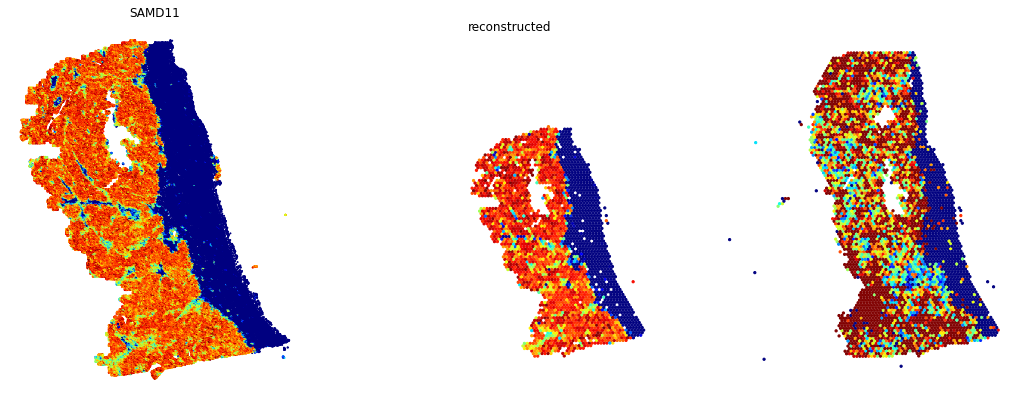

1
0.0 0.6391063439846043
0.0 0.6140145468711853
0.0 0.6140145468711853


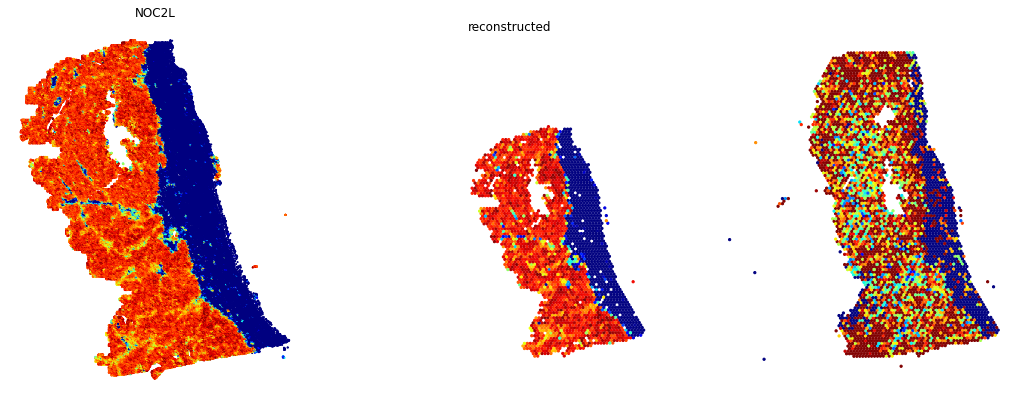

2
0.0 0.4073549157381058
0.0 0.36579478502273555
0.0 0.36579478502273555


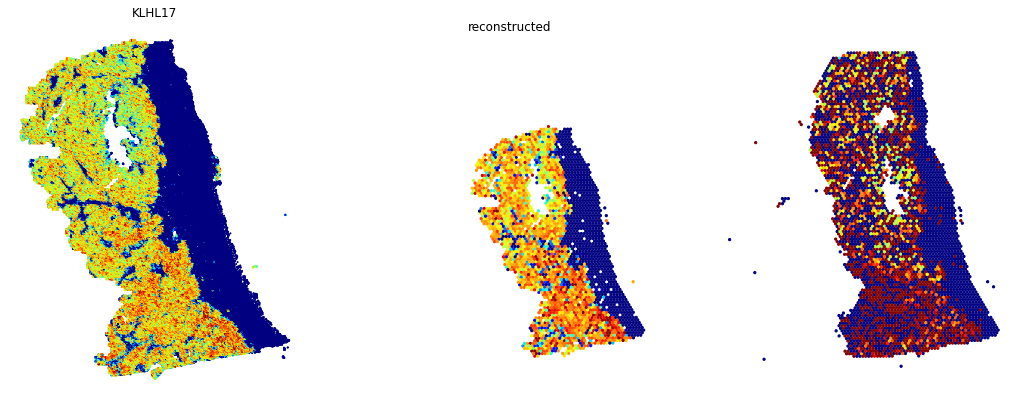

3
0.0 0.38411409020423903
0.0 0.3525043618679047
0.0 0.3525043618679047


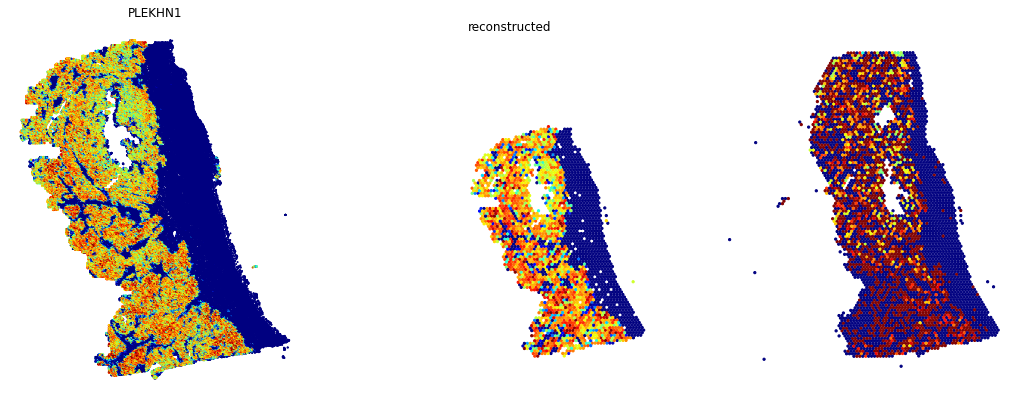

4
0.0 0.0
0.0 0.0
0.0 0.0


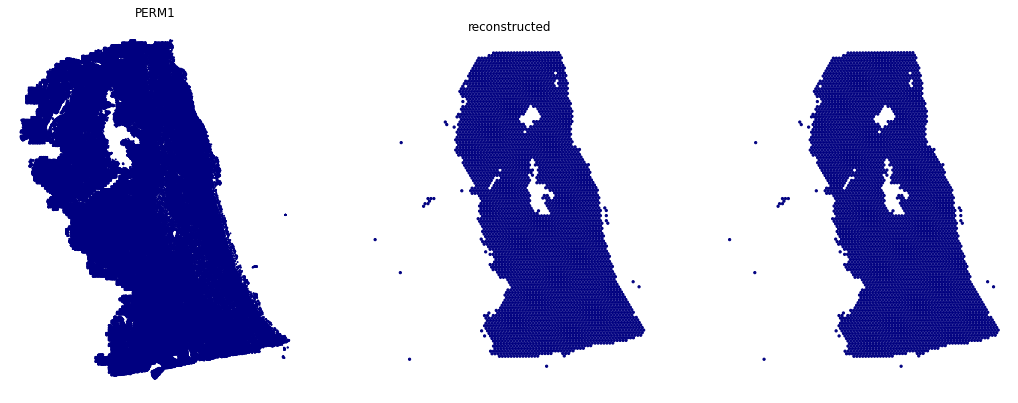

5
0.0 0.2967146784067155
0.0 0.27474241733551025
0.0 0.27474241733551025


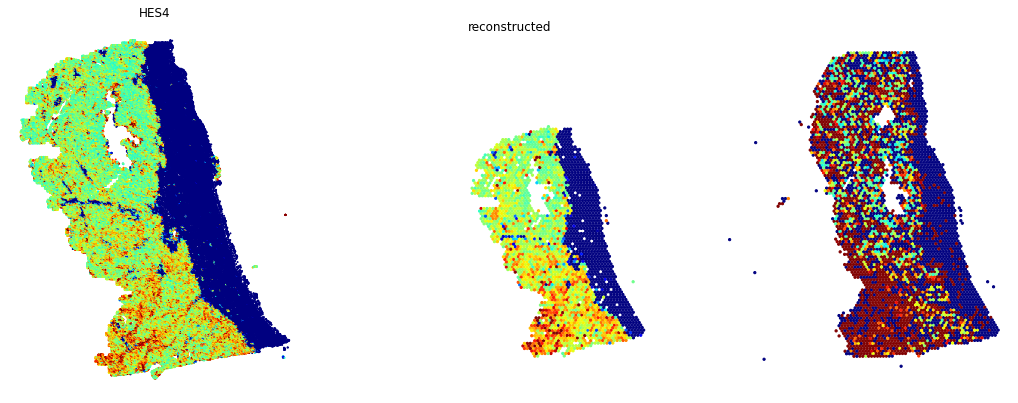

6
0.0 0.569617742300034
0.0 0.4927375006675718
0.0 0.4927375006675718


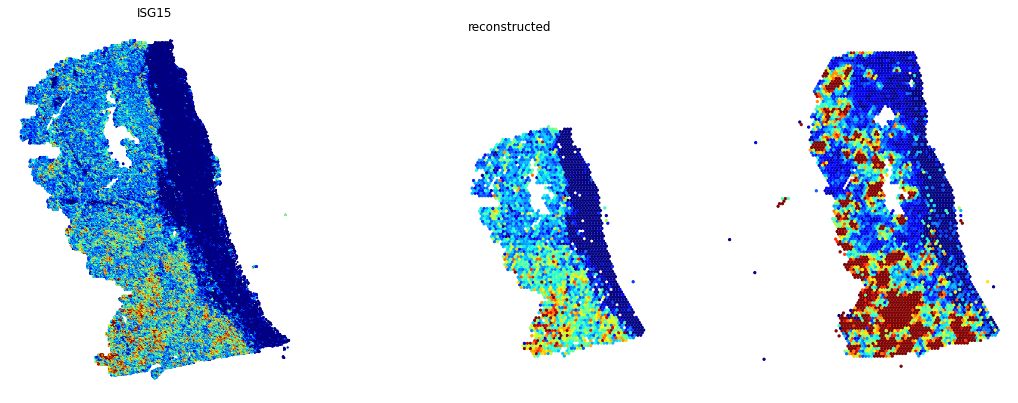

7
0.0 0.6616777026653291
0.0 0.6302967023849486
0.0 0.6302967023849486


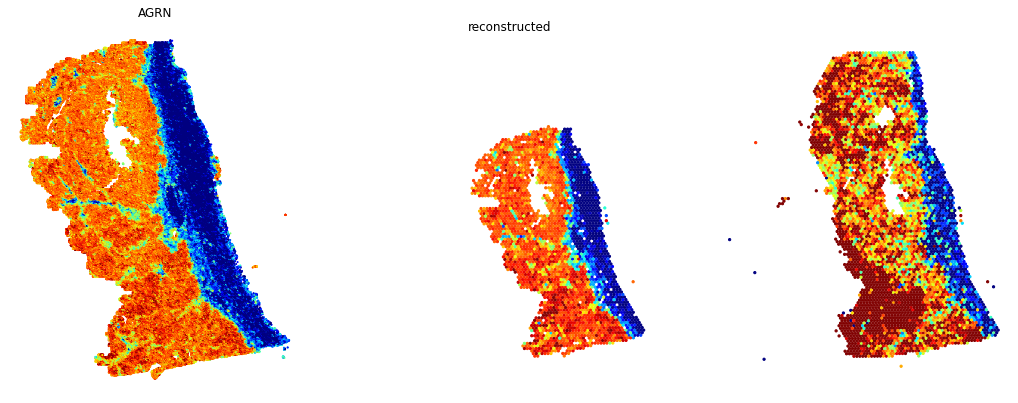

8
0.0 0.0
0.0 0.0
0.0 0.0


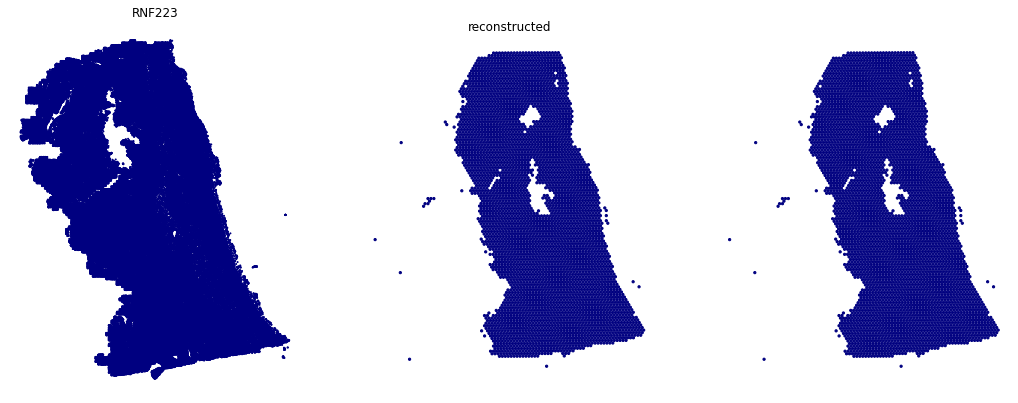

9
0.0 0.4653971496224404
0.0 0.42305048942565915
0.0 0.42305048942565915


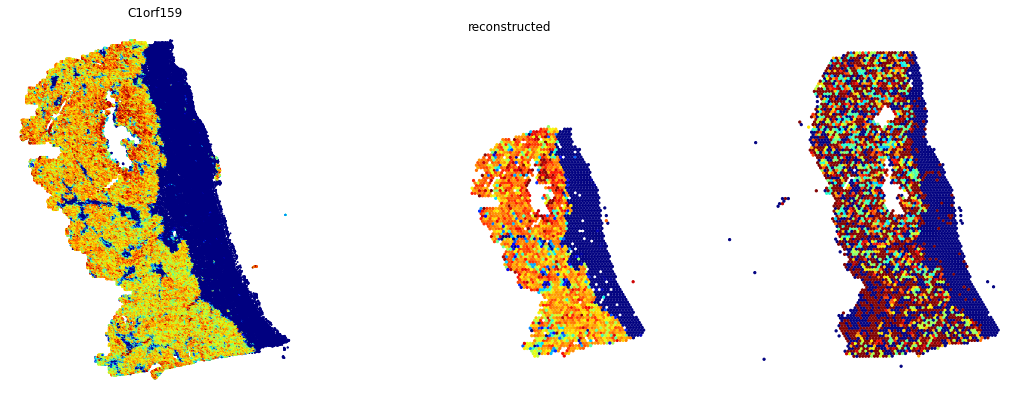

10
0.0 0.0
0.0 0.0
0.0 0.0


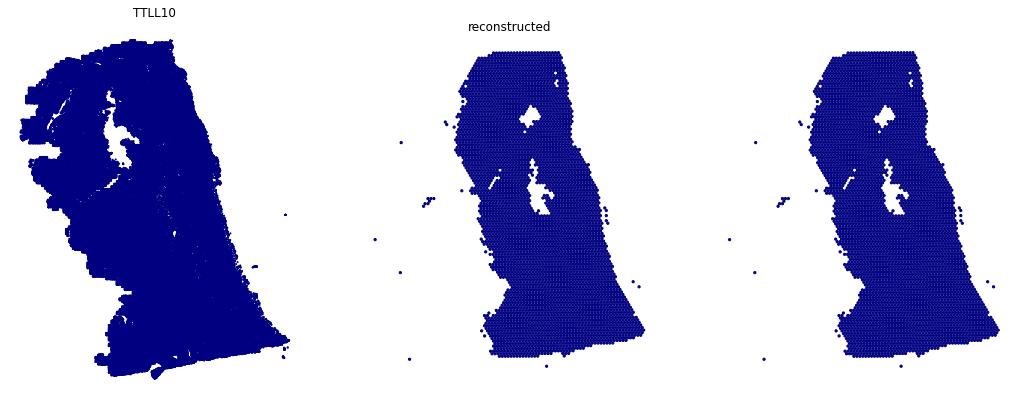

11
0.0 0.4174353489279752
0.0 0.31252287507057186
0.0 0.31252287507057186


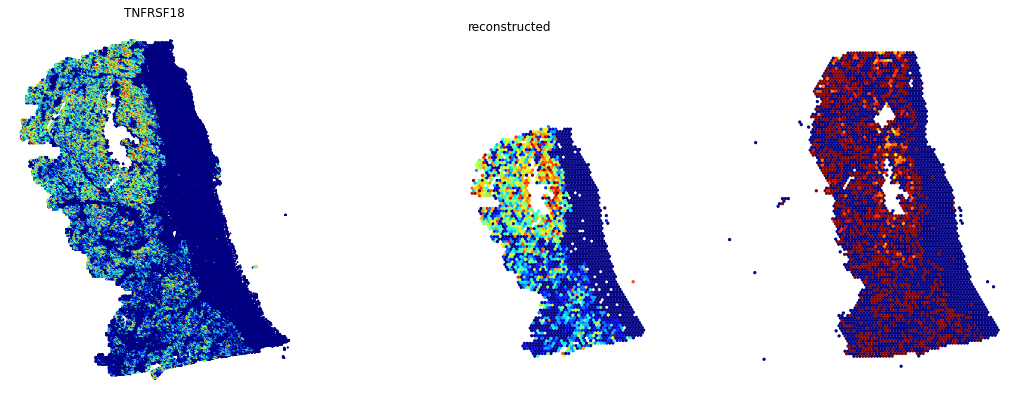

12
0.0 0.0
0.0 0.0
0.0 0.0


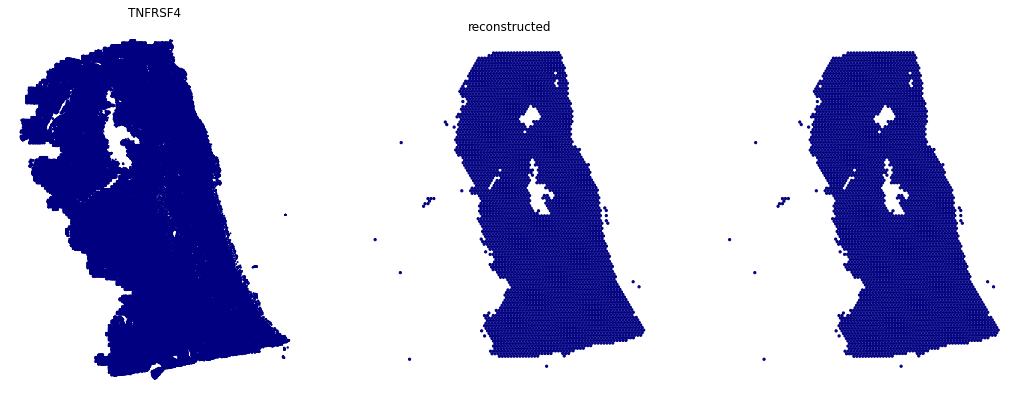

13
0.0 0.6308742678165438
0.057987848371267324 0.5937193632125854
0.057987848371267324 0.5937193632125854


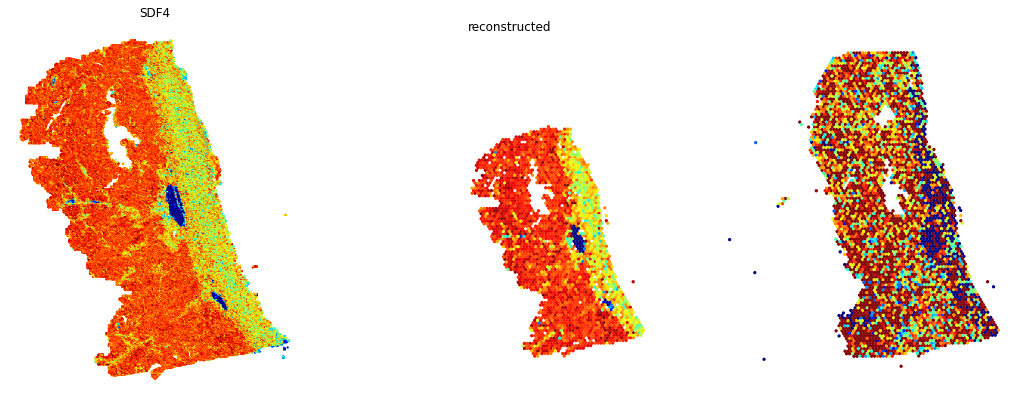

14
0.0 0.5302313113212586


KeyboardInterrupt: 

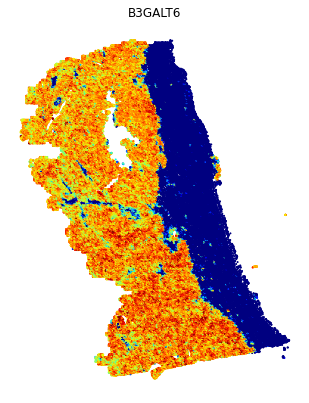

In [44]:
import matplotlib as mpl
from matplotlib import cm

for i, j in enumerate(range(20)):
    print(i)
    _image_feature = pred_counts[:, i]
    vmax = np.quantile(_image_feature, 0.99)
    vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.figure(figsize=(18, 9))
    plt.subplot(131)
    plt.scatter(coords_xs, coords_ys, c=_mycolor, s=1)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.title(count_df.columns.values[i])
    
    # Plot reconstruction
    _image_feature = pred_counts[:, i]
    spot_recon = []
    for spot_id in meta_df.index.values:
        spot_recon.append(np.average(_image_feature[nuclei_data_df.loc[cell_indexes, 'spot_id'].values == spot_id]))
    vmax = np.nanquantile(spot_recon, 0.99)
    vmin = np.nanquantile(spot_recon, 0.01)
    # _ = count_df.iloc[:, j]
    # vmax = np.quantile(_, 0.99)
    # vmin = np.quantile(_, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(spot_recon)
    plt.subplot(132)
    plt.scatter(spot_xs, spot_ys, c=_mycolor, s=5)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.title('reconstructed')

    _image_feature = count_df.iloc[:, j]
    # vmax = np.quantile(_image_feature, 0.99)
    # vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.subplot(133)
    plt.scatter(spot_xs, spot_ys, c=_mycolor, s=5)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

In [ ]:
pred_counts

0.0 0.6408584535121918


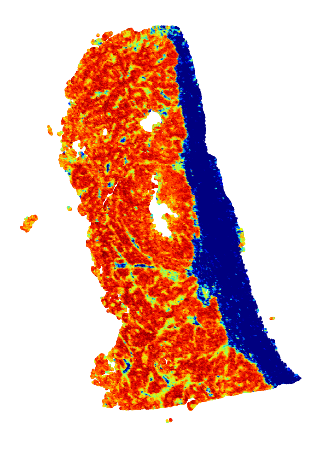

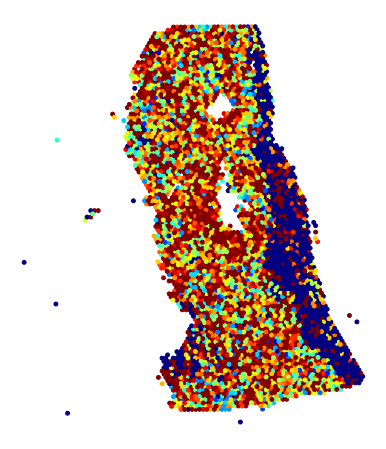

In [78]:
gene_name ='ERBB2'


import matplotlib as mpl
import matplotlib.cm as cm


##### Use the same color as deconvolution
_image_feature = pred_counts_df.loc[:, gene_name]
vmax = np.quantile(_image_feature, 0.99)
vmin = np.quantile(_image_feature, 0.01)
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
print(vmin, vmax)
cmap = cm.jet
m = cm.ScalarMappable(norm=norm, cmap=cmap)
    
##### plot1 deconvolution
fig, ax = plt.subplots(figsize=(8,8)) 
_mycolor = m.to_rgba(_image_feature)
plt.scatter(coords_xs, coords_ys, c=_mycolor, s=1)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

fig, ax = plt.subplots(figsize=(8,8))  
_image_feature = count_df.loc[:, gene_name]
# vmax = np.quantile(_image_feature, 0.99)
# vmin = np.quantile(_image_feature, 0.01)
#norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
#print(vmin, vmax)
#cmap = cm.jet
#m = cm.ScalarMappable(norm=norm, cmap=cmap)
_mycolor = m.to_rgba(_image_feature)
plt.scatter(spot_xs, spot_ys, c=_mycolor, s=15)
plt.gca().set_aspect('equal')
plt.axis('off')
plt.show()

In [48]:
Cancer_gene=['DUOX1', 'EGFR', 'FGFBP2', 'GKN2', 'KDR', 'LGR5', 'MYC', 'NFKB1', 'SLC2A1', 'SLC7A11', 'SOX2', 'SOX9']

Cancer_gene_find = [gene for gene in Cancer_gene if gene in count_df.columns]

Cancer_gene_find

['EGFR', 'FGFBP2', 'GKN2', 'KDR', 'NFKB1', 'SLC2A1', 'SLC7A11', 'SOX2', 'SOX9']

EGFR
0.0 0.34345745742321077
0.0 0.34345745742321077


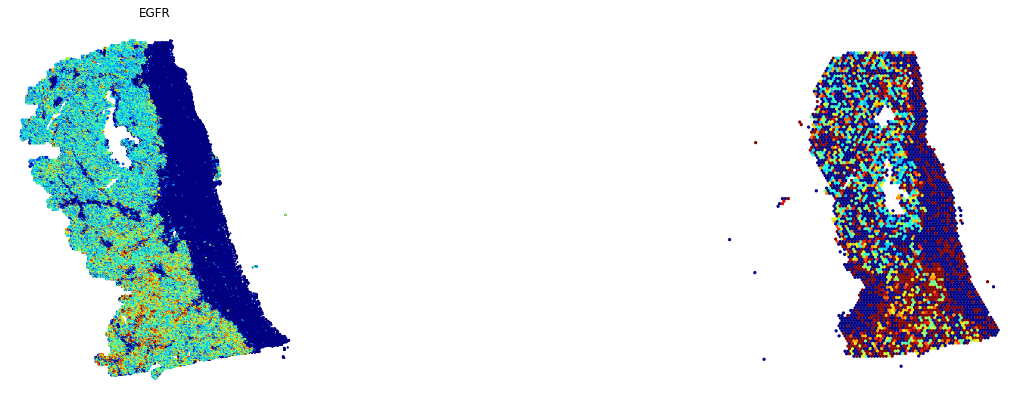

FGFBP2
0.0 0.0
0.0 0.0


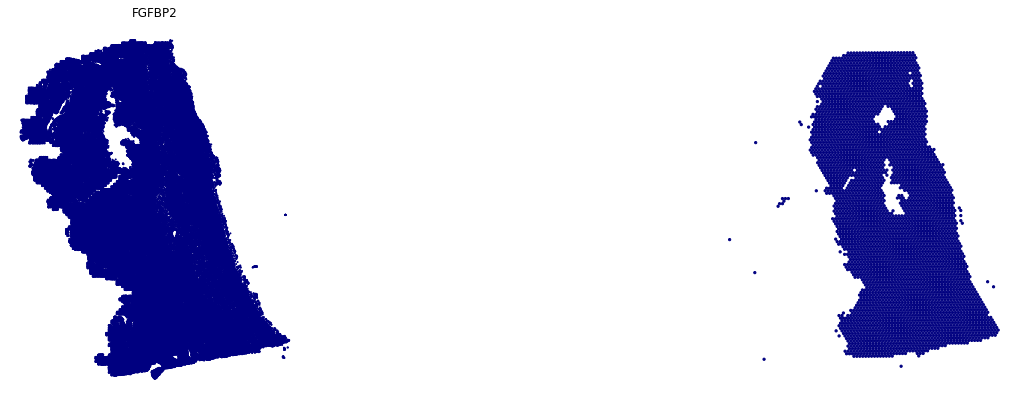

GKN2
0.0 0.0
0.0 0.0


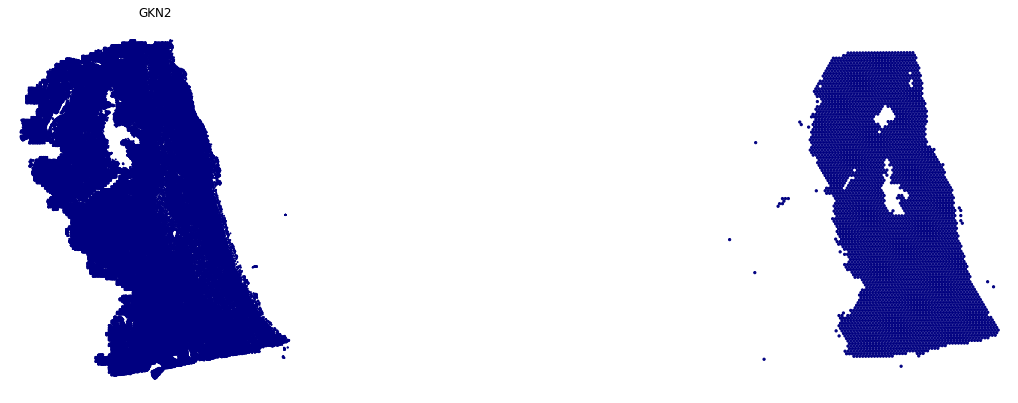

KDR
0.0 0.0
0.0 0.0


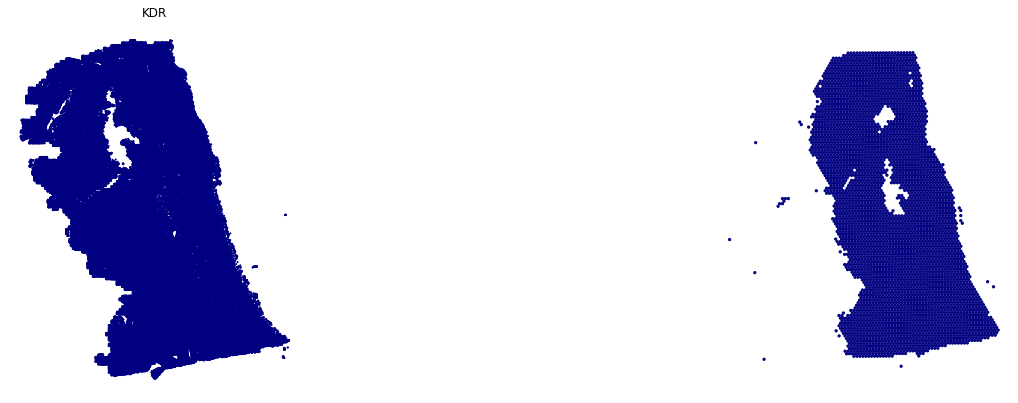

NFKB1
0.0 0.4583613318204883
0.0 0.4583613318204883


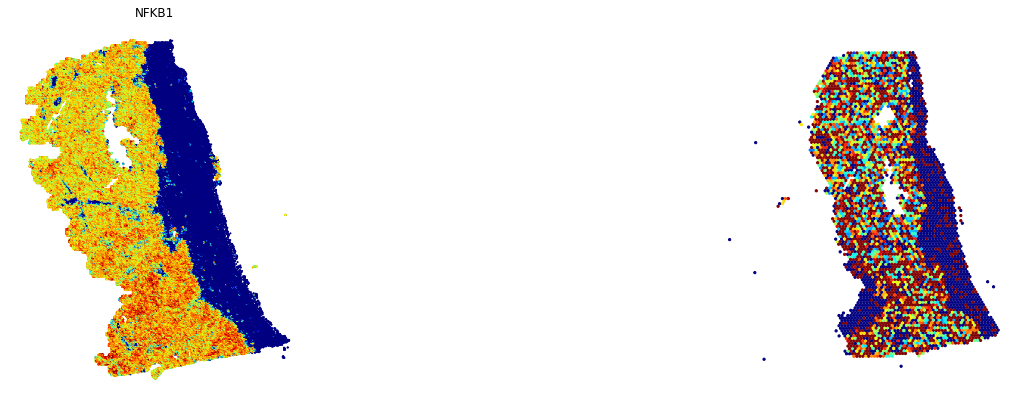

SLC2A1
0.0 0.4758092951774599
0.0 0.4758092951774599


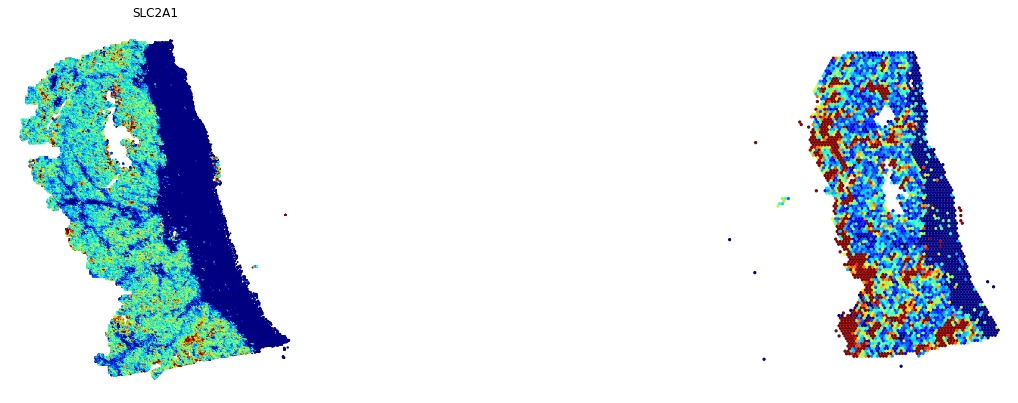

SLC7A11
0.0 0.0
0.0 0.0


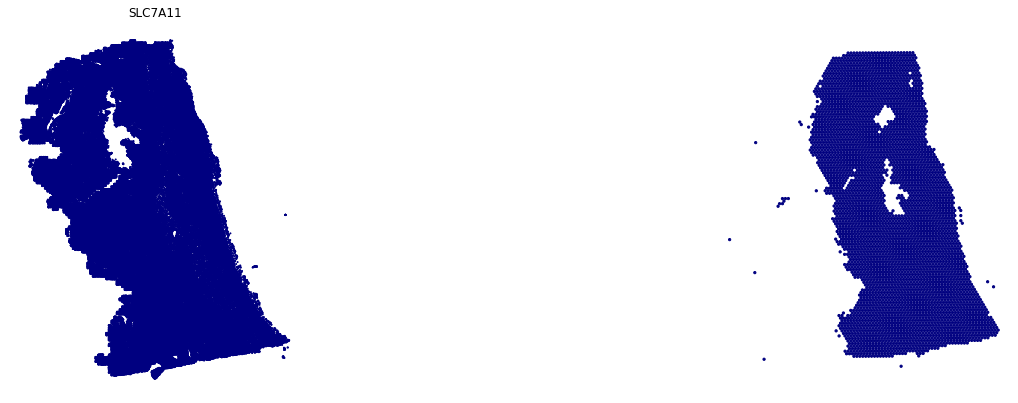

SOX2
0.0 0.0
0.0 0.0


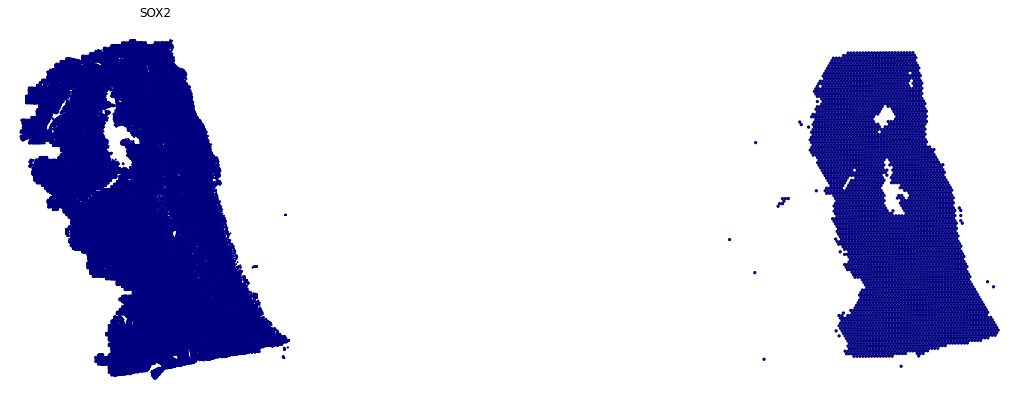

SOX9
0.0 0.44052593469619794
0.0 0.44052593469619794


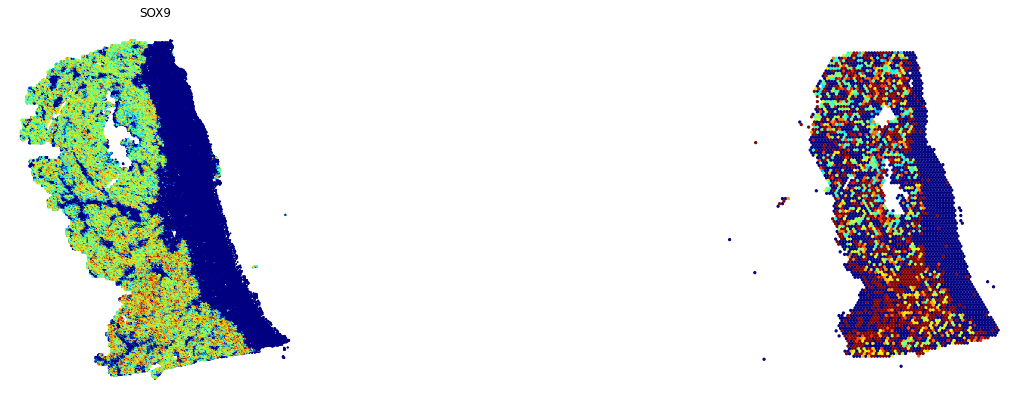

In [50]:
import matplotlib as mpl
from matplotlib import cm

for gene in Cancer_gene_find:

    print(gene)
    _image_feature = pred_counts_df[ gene]
    vmax = np.quantile(_image_feature, 0.99)
    vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.figure(figsize=(18, 9))
    plt.subplot(131)
    plt.scatter(coords_xs, coords_ys, c=_mycolor, s=1)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.title(gene)
    


    _image_feature = count_df[ gene]
    # vmax = np.quantile(_image_feature, 0.99)
    # vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.subplot(133)
    plt.scatter(spot_xs, spot_ys, c=_mycolor, s=5)
    plt.gca().set_aspect('equal')
    plt.axis('off')
    plt.show()

ERBB2
0.0 0.6408584535121918
0.0 0.6408584535121918


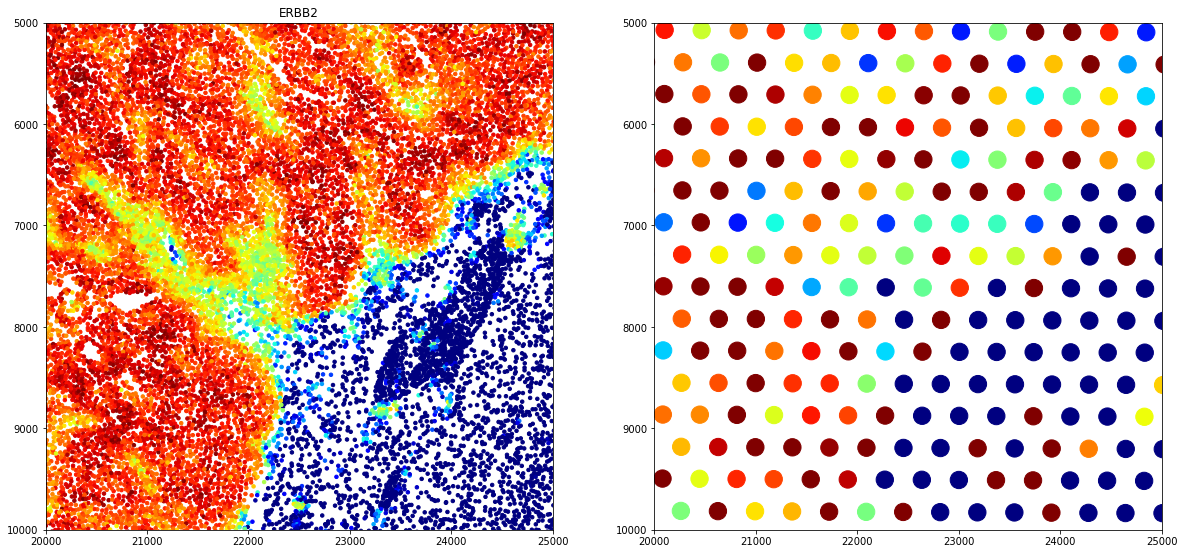

In [75]:
import matplotlib as mpl
from matplotlib import cm

for gene in ['ERBB2']:

    print(gene)
    _image_feature = pred_counts_df[ gene]
    vmax = np.quantile(_image_feature, 0.99)
    vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.scatter(coords_xs, coords_ys, c=_mycolor, s=12)
    plt.gca().set_aspect('equal')
    plt.ylim(10000, 5000)
    plt.xlim(20000, 25000)
    plt.axis('on')
    plt.title(gene)
    


    _image_feature = count_df[ gene]
    # vmax = np.quantile(_image_feature, 0.99)
    # vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.subplot(122)
    plt.scatter(spot_xs, spot_ys, c=_mycolor, s=300)
    plt.gca().set_aspect('equal')
    plt.ylim(10000, 5000)
    plt.xlim(20000, 25000)
    plt.axis('on')
    plt.show()

CD4
0.0 0.32895467877388
0.0 0.32895467877388


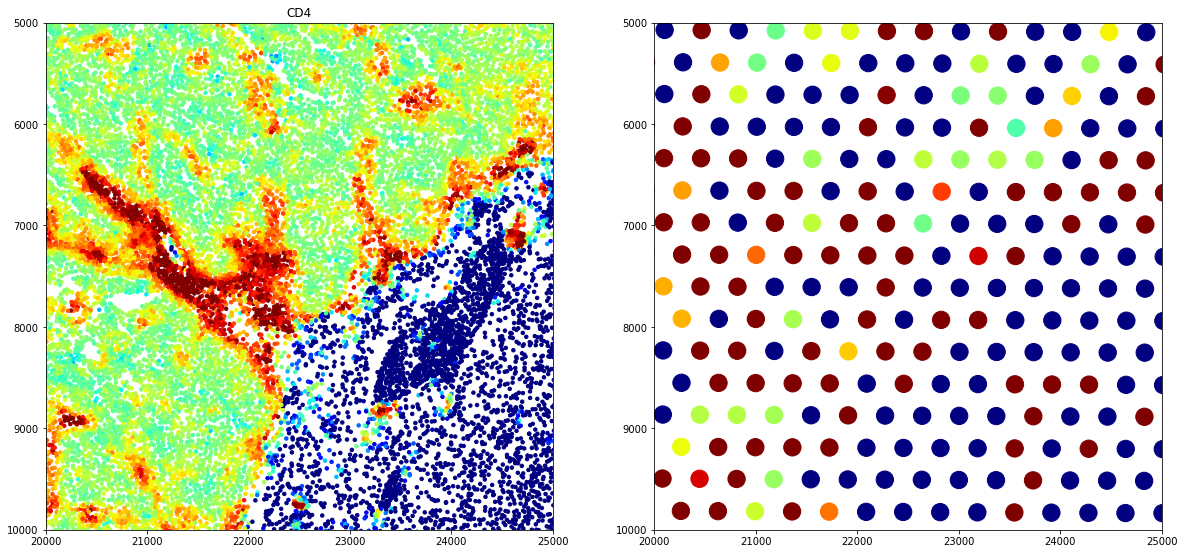

In [77]:
import matplotlib as mpl
from matplotlib import cm

for gene in ['CD4']:

    print(gene)
    _image_feature = pred_counts_df[ gene]
    vmax = np.quantile(_image_feature, 0.99)
    vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.figure(figsize=(20, 20))
    plt.subplot(121)
    plt.scatter(coords_xs, coords_ys, c=_mycolor, s=12)
    plt.gca().set_aspect('equal')
    plt.ylim(10000, 5000)
    plt.xlim(20000, 25000)
    plt.axis('on')
    plt.title(gene)
    


    _image_feature = count_df[ gene]
    # vmax = np.quantile(_image_feature, 0.99)
    # vmin = np.quantile(_image_feature, 0.01)
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    print(vmin, vmax)
    cmap = cm.jet
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    _mycolor = m.to_rgba(_image_feature)
    plt.subplot(122)
    plt.scatter(spot_xs, spot_ys, c=_mycolor, s=300)
    plt.gca().set_aspect('equal')
    plt.ylim(10000, 5000)
    plt.xlim(20000, 25000)
    plt.axis('on')
    plt.show()

# Export

In [69]:
pred_counts_df = pd.DataFrame(pred_counts, index=cell_indexes, columns=count_df.columns.values)

In [70]:
pred_counts_df

SIGIRR  NTS  PRKCQ   SLC66A1    NDUFS1  CFAP58  FOLH1     XRCC1  \
0       0.292641  0.0    0.0  0.287341  0.387269     0.0    0.0  0.395832   
8       0.261062  0.0    0.0  0.269200  0.355880     0.0    0.0  0.360125   
1       0.293643  0.0    0.0  0.283132  0.385831     0.0    0.0  0.382861   
3       0.282094  0.0    0.0  0.252900  0.362045     0.0    0.0  0.368764   
4       0.232919  0.0    0.0  0.206867  0.302830     0.0    0.0  0.298688   
...          ...  ...    ...       ...       ...     ...    ...       ...   
364658  0.000000  0.0    0.0  0.000000  0.000000     0.0    0.0  0.000000   
364659  0.000000  0.0    0.0  0.000000  0.005402     0.0    0.0  0.072971   
364660  0.000000  0.0    0.0  0.000000  0.000000     0.0    0.0  0.000000   
364661  0.000000  0.0    0.0  0.000000  0.000000     0.0    0.0  0.067922   
364662  0.000000  0.0    0.0  0.000000  0.000000     0.0    0.0  0.038622   

        RBFOX3  FAM200A  ...  HIST1H4B   ARFGAP2     RNPS1    ZNF343  RSPO2  \
0          0.0      0.0  ...       0.0  0.071376  0.545376  0.326988    0.0   
8          0.0      0.0  ...       0.0  0.052765  0.521001  0.302762    0.0   
1          0.0      0.0  ...       0.0  0.122619  0.556964  0.353421    0.0   
3          0.0      0.0  ...       0.0  0.071650  0.525052  0.311905    0.0   
4          0.0      0.0  ...       0.0  0.078315  0.473648  0.281210    0.0   
...        ...      ...  ...       ...       ...       ...       ...    ...   
364658     0.0      0.0  ...       0.0  0.000000  0.000000  0.000000    0.0   
364659     0.0      0.0  ...       0.0  0.000000  0.115287  0.000000    0.0   
364660     0.0      0.0  ...       0.0  0.000000  0.000000  0.000000    0.0   
364661     0.0      0.0  ...       0.0  0.000000  0.109126  0.000000    0.0   
364662     0.0      0.0  ...       0.0  0.000000  0.046983  0.000000    0.0   

         ZKSCAN8    KANSL3    HSPA14      TBCE  TMSB15B  
0       0.374329  0.454943  0.336333  0.372022      0.0  
8       0.347192  0.418892  0.308030  0.355491      0.0  
1       0.381306  0.451564  0.333499  0.406111      0.0  
3       0.353706  0.408192  0.325474  0.361425      0.0  
4       0.300788  0.342516  0.275407  0.337214      0.0  
...          ...       ...       ...       ...      ...  
364658  0.000000  0.010101  0.000000  0.000000      0.0  
364659  0.000000  0.096835  0.000000  0.000000      0.0  
364660  0.000000  0.000000  0.000000  0.000000      0.0  
364661  0.000000  0.211704  0.000000  0.000000      0.0  
364662  0.000000  0.109565  0.000000  0.000000      0.0  

[364531 rows x 18061 columns]

In [71]:
pred_counts_df.to_csv(os.path.join(output_dir, '2_pred_count_1370_gene_zhuoyu.csv'))

In [79]:
# Filter columns with non-zero values
non_zero_columns = pred_counts_df.columns[(pred_counts_df != 0).any()]

# Select columns with non-zero values
pred_counts_non_zero_df = pred_counts_df[non_zero_columns]



In [81]:
pred_counts_non_zero_df

SIGIRR   SLC66A1    NDUFS1     XRCC1  FAM200A      NUMB     TBCEL  \
0       0.292641  0.287341  0.387269  0.395832      0.0  0.216397  0.172618   
8       0.261062  0.269200  0.355880  0.360125      0.0  0.202239  0.155820   
1       0.293643  0.283132  0.385831  0.382861      0.0  0.231495  0.195491   
3       0.282094  0.252900  0.362045  0.368764      0.0  0.211360  0.168578   
4       0.232919  0.206867  0.302830  0.298688      0.0  0.189120  0.156936   
...          ...       ...       ...       ...      ...       ...       ...   
364658  0.000000  0.000000  0.000000  0.000000      0.0  0.000000  0.000000   
364659  0.000000  0.000000  0.005402  0.072971      0.0  0.000000  0.000000   
364660  0.000000  0.000000  0.000000  0.000000      0.0  0.000000  0.000000   
364661  0.000000  0.000000  0.000000  0.067922      0.0  0.000000  0.000000   
364662  0.000000  0.000000  0.000000  0.038622      0.0  0.000000  0.000000   

            EPC2  TIMM8A    SACM1L  ...      PDHB      E2F3  DCP2   ARFGAP2  \
0       0.474448     0.0  0.273824  ...  0.278563  0.184380   0.0  0.071376   
8       0.443460     0.0  0.254756  ...  0.256735  0.161261   0.0  0.052765   
1       0.472120     0.0  0.279536  ...  0.299022  0.223196   0.0  0.122619   
3       0.449877     0.0  0.267961  ...  0.269894  0.171228   0.0  0.071650   
4       0.398106     0.0  0.241466  ...  0.239596  0.153968   0.0  0.078315   
...          ...     ...       ...  ...       ...       ...   ...       ...   
364658  0.018679     0.0  0.000000  ...  0.000000  0.000000   0.0  0.000000   
364659  0.111638     0.0  0.000000  ...  0.000000  0.000000   0.0  0.000000   
364660  0.000000     0.0  0.000000  ...  0.000000  0.000000   0.0  0.000000   
364661  0.192751     0.0  0.000000  ...  0.000000  0.000000   0.0  0.000000   
364662  0.109455     0.0  0.000000  ...  0.000000  0.000000   0.0  0.000000   

           RNPS1    ZNF343   ZKSCAN8    KANSL3    HSPA14      TBCE  
0       0.545376  0.326988  0.374329  0.454943  0.336333  0.372022  
8       0.521001  0.302762  0.347192  0.418892  0.308030  0.355491  
1       0.556964  0.353421  0.381306  0.451564  0.333499  0.406111  
3       0.525052  0.311905  0.353706  0.408192  0.325474  0.361425  
4       0.473648  0.281210  0.300788  0.342516  0.275407  0.337214  
...          ...       ...       ...       ...       ...       ...  
364658  0.000000  0.000000  0.000000  0.010101  0.000000  0.000000  
364659  0.115287  0.000000  0.000000  0.096835  0.000000  0.000000  
364660  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  
364661  0.109126  0.000000  0.000000  0.211704  0.000000  0.000000  
364662  0.046983  0.000000  0.000000  0.109565  0.000000  0.000000  

[364531 rows x 9737 columns]

In [82]:
# Save to CSV
pred_counts_non_zero_df.to_csv(os.path.join(output_dir, '2_pred_count_all_gene_zhuoyu_nonzero.csv'))

In [83]:
print(sum(pred_counts_df['ZSCAN9']))
sum(pred_counts_non_zero_df['ZSCAN9'])

97359.21448200935


97359.21448200935